In [2]:
import nltk
import numpy as np
from tqdm.notebook import tqdm_notebook 
import tqdm
import pandas as pd
import os
import math
import warnings
warnings.filterwarnings('ignore')
import argparse
import timeit

from ir_system import IRSystem

Reading and separating documents

In [3]:
ExpReg = nltk. RegexpTokenizer('(?:[A-Za-z]\.)+|\d+(?:\.\d+)?%?|\w+(?:\-\w+)*')
MotsVides = nltk.corpus.stopwords.words('english')
Porter = nltk.PorterStemmer()
Lancaster = nltk.LancasterStemmer()

In [11]:
def load_data(path):
    
    
    #_____________ Read data from CISI.ALL file and store in dictinary ________________
    
    with open(os.path.join(path, 'CISI.ALL')) as f:
        lines = ""
        for l in f.readlines():
            lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
        lines = lines.lstrip("\n").split("\n")
 
    doc_set = {}
    doc_id = ""
    doc_text = ""

    for l in lines:
        if l.startswith(".I"):
            doc_id = l.split(" ")[1].strip() 
        elif l.startswith(".X"):
            doc_set[doc_id] = doc_text.lstrip(" ")
            doc_id = ""
            doc_text = ""
        elif l.startswith(".T") or l.startswith(".W"):
            doc_text += l.strip()[3:] + " "

    print(f"Number of documents = {len(doc_set)}")
    print(doc_set["1"]) 
    
    
    #_____________ Read data from CISI.QRY file and store in dictinary ________________
    
    with open(os.path.join(path, 'CISI.QRY')) as f:
        lines = ""
        for l in f.readlines():
            lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
        lines = lines.lstrip("\n").split("\n")
          
    qry_set = {}
    qry_id = ""
    for l in lines:
        if l.startswith(".I"):
            qry_id = l.split(" ")[1].strip() 
        elif l.startswith(".W"):
            qry_set[qry_id] = l.strip()[3:]
            qry_id = ""

    print(f"\n\nNumber of queries = {len(qry_set)}")    
    print(qry_set["1"]) 
    
    
    #_____________ Read data from CISI.REL file and store in dictinary ________________
    
    rel_set = {}
    with open(os.path.join(path, 'CISI.REL')) as f:
        for l in f.readlines():
            qry_id = l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[0] 
            doc_id = l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[-1]

            if qry_id in rel_set:
                rel_set[qry_id].append(doc_id)
            else:
                rel_set[qry_id] = []
                rel_set[qry_id].append(doc_id)

    print(f"\n\nNumber of mappings = {len(rel_set)}")
    print(rel_set["1"]) 
    
    doc_set = {int(id):doc for (id,doc) in doc_set.items()}
    qry_set = {int(id):qry for (id,qry) in qry_set.items()}
    rel_set = {int(qid):list(map(int, did_lst)) for (qid,did_lst) in rel_set.items()}
    
    return doc_set, qry_set, rel_set

In [12]:
doc_set, qry_set, rel_set = load_data('documents')

Number of documents = 1460
18 Editions of the Dewey Decimal Classifications The present study is a history of the DEWEY Decimal Classification.  The first edition of the DDC was published in 1876, the eighteenth edition in 1971, and future editions will continue to appear as needed.  In spite of the DDC's long and healthy life, however, its full story has never been told.  There have been biographies of Dewey that briefly describe his system, but this is the first attempt to provide a detailed history of the work that more than any other has spurred the growth of librarianship in this country and abroad. 


Number of queries = 112
What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?


Number of mappings = 76
['28', '35', '38', '42', '43', '52', '65', '76', '86', '150', '189', '192', '193', '195', '215', '26

Separating words

In [13]:

dico_terms = {}
for key in doc_set.keys():
    #termes = doc_set[key].split(" ")
    termes = ExpReg.tokenize(doc_set[key])
    dico_terms[key] = termes

dico_terms

{1: ['18',
  'Editions',
  'of',
  'the',
  'Dewey',
  'Decimal',
  'Classifications',
  'The',
  'present',
  'study',
  'is',
  'a',
  'history',
  'of',
  'the',
  'DEWEY',
  'Decimal',
  'Classification',
  'The',
  'first',
  'edition',
  'of',
  'the',
  'DDC',
  'was',
  'published',
  'in',
  '1876',
  'the',
  'eighteenth',
  'edition',
  'in',
  '1971',
  'and',
  'future',
  'editions',
  'will',
  'continue',
  'to',
  'appear',
  'as',
  'needed',
  'In',
  'spite',
  'of',
  'the',
  'DDC',
  's',
  'long',
  'and',
  'healthy',
  'life',
  'however',
  'its',
  'full',
  'story',
  'has',
  'never',
  'been',
  'told',
  'There',
  'have',
  'been',
  'biographies',
  'of',
  'Dewey',
  'that',
  'briefly',
  'describe',
  'his',
  'system',
  'but',
  'this',
  'is',
  'the',
  'first',
  'attempt',
  'to',
  'provide',
  'a',
  'detailed',
  'history',
  'of',
  'the',
  'work',
  'that',
  'more',
  'than',
  'any',
  'other',
  'has',
  'spurred',
  'the',
  'growth'

Stemming words

In [5]:


doc_stems_porter = {}
doc_stems_lancaster = {}
for key in dico_terms.keys():
    TermesSansMotsVides_p = [Porter.stem(terme) for terme in dico_terms[key] if terme.lower() not in MotsVides]
    TermesSansMotsVides_l = [Lancaster.stem(terme) for terme in dico_terms[key] if terme.lower() not in MotsVides]
    doc_stems_porter[key] = TermesSansMotsVides_p
    doc_stems_lancaster[key] = TermesSansMotsVides_l

doc_stems_porter


{1: ['18',
  'edit',
  'dewey',
  'decim',
  'classif',
  'present',
  'studi',
  'histori',
  'dewey',
  'decim',
  'classif',
  'first',
  'edit',
  'ddc',
  'publish',
  '1876',
  'eighteenth',
  'edit',
  '1971',
  'futur',
  'edit',
  'continu',
  'appear',
  'need',
  'spite',
  'ddc',
  'long',
  'healthi',
  'life',
  'howev',
  'full',
  'stori',
  'never',
  'told',
  'biographi',
  'dewey',
  'briefli',
  'describ',
  'system',
  'first',
  'attempt',
  'provid',
  'detail',
  'histori',
  'work',
  'spur',
  'growth',
  'librarianship',
  'countri',
  'abroad'],
 2: ['use',
  'made',
  'technic',
  'librari',
  'report',
  'analysi',
  '6300',
  'act',
  'use',
  '104',
  'technic',
  'librari',
  'unit',
  'kingdom',
  'librari',
  'use',
  'one',
  'aspect',
  'wider',
  'pattern',
  'inform',
  'use',
  'inform',
  'transfer',
  'librari',
  'restrict',
  'use',
  'document',
  'take',
  'account',
  'document',
  'use',
  'outsid',
  'librari',
  'still',
  'less',
  'i

Calculate frequencies for each word

In [6]:
def descripteur(dico):
    TermesFrequence = {}
    for key in dico.keys():
        for terme in dico[key]:
            if (key,terme) in TermesFrequence.keys():
                TermesFrequence[(key,terme)] += 1
            else:
                TermesFrequence[(key,terme)] = 1
    return TermesFrequence

In [7]:
freqs_porter = descripteur(doc_stems_porter)
freqs_porter

{(1, '18'): 1,
 (1, 'edit'): 4,
 (1, 'dewey'): 3,
 (1, 'decim'): 2,
 (1, 'classif'): 2,
 (1, 'present'): 1,
 (1, 'studi'): 1,
 (1, 'histori'): 2,
 (1, 'first'): 2,
 (1, 'ddc'): 2,
 (1, 'publish'): 1,
 (1, '1876'): 1,
 (1, 'eighteenth'): 1,
 (1, '1971'): 1,
 (1, 'futur'): 1,
 (1, 'continu'): 1,
 (1, 'appear'): 1,
 (1, 'need'): 1,
 (1, 'spite'): 1,
 (1, 'long'): 1,
 (1, 'healthi'): 1,
 (1, 'life'): 1,
 (1, 'howev'): 1,
 (1, 'full'): 1,
 (1, 'stori'): 1,
 (1, 'never'): 1,
 (1, 'told'): 1,
 (1, 'biographi'): 1,
 (1, 'briefli'): 1,
 (1, 'describ'): 1,
 (1, 'system'): 1,
 (1, 'attempt'): 1,
 (1, 'provid'): 1,
 (1, 'detail'): 1,
 (1, 'work'): 1,
 (1, 'spur'): 1,
 (1, 'growth'): 1,
 (1, 'librarianship'): 1,
 (1, 'countri'): 1,
 (1, 'abroad'): 1,
 (2, 'use'): 6,
 (2, 'made'): 1,
 (2, 'technic'): 4,
 (2, 'librari'): 8,
 (2, 'report'): 1,
 (2, 'analysi'): 1,
 (2, '6300'): 1,
 (2, 'act'): 2,
 (2, '104'): 1,
 (2, 'unit'): 1,
 (2, 'kingdom'): 1,
 (2, 'one'): 2,
 (2, 'aspect'): 1,
 (2, 'wider'): 1,
 

In [8]:
freqs_lan = descripteur(doc_stems_lancaster)
freqs_lan

{(1, '18'): 1,
 (1, 'edit'): 4,
 (1, 'dewey'): 3,
 (1, 'decim'): 2,
 (1, 'class'): 2,
 (1, 'pres'): 1,
 (1, 'study'): 1,
 (1, 'hist'): 2,
 (1, 'first'): 2,
 (1, 'ddc'): 2,
 (1, 'publ'): 1,
 (1, '1876'): 1,
 (1, 'eighteen'): 1,
 (1, '1971'): 1,
 (1, 'fut'): 1,
 (1, 'continu'): 1,
 (1, 'appear'): 1,
 (1, 'nee'): 1,
 (1, 'spit'): 1,
 (1, 'long'): 1,
 (1, 'healthy'): 1,
 (1, 'lif'): 1,
 (1, 'howev'): 1,
 (1, 'ful'): 1,
 (1, 'story'): 1,
 (1, 'nev'): 1,
 (1, 'told'): 1,
 (1, 'biograph'): 1,
 (1, 'brief'): 1,
 (1, 'describ'): 1,
 (1, 'system'): 1,
 (1, 'attempt'): 1,
 (1, 'provid'): 1,
 (1, 'detail'): 1,
 (1, 'work'): 1,
 (1, 'spur'): 1,
 (1, 'grow'): 1,
 (1, 'libr'): 1,
 (1, 'country'): 1,
 (1, 'abroad'): 1,
 (2, 'us'): 8,
 (2, 'mad'): 1,
 (2, 'techn'): 4,
 (2, 'libr'): 8,
 (2, 'report'): 1,
 (2, 'analys'): 1,
 (2, '6300'): 1,
 (2, 'act'): 2,
 (2, '104'): 1,
 (2, 'unit'): 1,
 (2, 'kingdom'): 1,
 (2, 'on'): 2,
 (2, 'aspect'): 1,
 (2, 'wid'): 1,
 (2, 'pattern'): 1,
 (2, 'inform'): 7,
 (2, 'tr

Calculate frequencies inverse

In [9]:
def descripteur_inverse(dico):
    TermesFrequence = {}
    for key in dico.keys():
        for terme in dico[key]:
            if (terme,key) in TermesFrequence.keys():
                TermesFrequence[(terme,key)] += 1
            else:
                TermesFrequence[(terme,key)] = 1
        for k in dico.keys():
            if k != key:
                for t in dico[k]:
                    if t not in dico[key]:
                        TermesFrequence[(t,key)] = 0
    return TermesFrequence

In [10]:
inverse_p = descripteur_inverse(doc_stems_porter)
inverse_p

{('18', 1): 1,
 ('edit', 1): 4,
 ('dewey', 1): 3,
 ('decim', 1): 2,
 ('classif', 1): 2,
 ('present', 1): 1,
 ('studi', 1): 1,
 ('histori', 1): 2,
 ('first', 1): 2,
 ('ddc', 1): 2,
 ('publish', 1): 1,
 ('1876', 1): 1,
 ('eighteenth', 1): 1,
 ('1971', 1): 1,
 ('futur', 1): 1,
 ('continu', 1): 1,
 ('appear', 1): 1,
 ('need', 1): 1,
 ('spite', 1): 1,
 ('long', 1): 1,
 ('healthi', 1): 1,
 ('life', 1): 1,
 ('howev', 1): 1,
 ('full', 1): 1,
 ('stori', 1): 1,
 ('never', 1): 1,
 ('told', 1): 1,
 ('biographi', 1): 1,
 ('briefli', 1): 1,
 ('describ', 1): 1,
 ('system', 1): 1,
 ('attempt', 1): 1,
 ('provid', 1): 1,
 ('detail', 1): 1,
 ('work', 1): 1,
 ('spur', 1): 1,
 ('growth', 1): 1,
 ('librarianship', 1): 1,
 ('countri', 1): 1,
 ('abroad', 1): 1,
 ('use', 1): 0,
 ('made', 1): 0,
 ('technic', 1): 0,
 ('librari', 1): 0,
 ('report', 1): 0,
 ('analysi', 1): 0,
 ('6300', 1): 0,
 ('act', 1): 0,
 ('104', 1): 0,
 ('unit', 1): 0,
 ('kingdom', 1): 0,
 ('one', 1): 0,
 ('aspect', 1): 0,
 ('wider', 1): 0,
 

In [11]:
inverse_l = descripteur_inverse(doc_stems_lancaster)
inverse_l

{('18', 1): 1,
 ('edit', 1): 4,
 ('dewey', 1): 3,
 ('decim', 1): 2,
 ('class', 1): 2,
 ('pres', 1): 1,
 ('study', 1): 1,
 ('hist', 1): 2,
 ('first', 1): 2,
 ('ddc', 1): 2,
 ('publ', 1): 1,
 ('1876', 1): 1,
 ('eighteen', 1): 1,
 ('1971', 1): 1,
 ('fut', 1): 1,
 ('continu', 1): 1,
 ('appear', 1): 1,
 ('nee', 1): 1,
 ('spit', 1): 1,
 ('long', 1): 1,
 ('healthy', 1): 1,
 ('lif', 1): 1,
 ('howev', 1): 1,
 ('ful', 1): 1,
 ('story', 1): 1,
 ('nev', 1): 1,
 ('told', 1): 1,
 ('biograph', 1): 1,
 ('brief', 1): 1,
 ('describ', 1): 1,
 ('system', 1): 1,
 ('attempt', 1): 1,
 ('provid', 1): 1,
 ('detail', 1): 1,
 ('work', 1): 1,
 ('spur', 1): 1,
 ('grow', 1): 1,
 ('libr', 1): 1,
 ('country', 1): 1,
 ('abroad', 1): 1,
 ('us', 1): 0,
 ('mad', 1): 0,
 ('techn', 1): 0,
 ('report', 1): 0,
 ('analys', 1): 0,
 ('6300', 1): 0,
 ('act', 1): 0,
 ('104', 1): 0,
 ('unit', 1): 0,
 ('kingdom', 1): 0,
 ('on', 1): 0,
 ('aspect', 1): 0,
 ('wid', 1): 0,
 ('pattern', 1): 0,
 ('inform', 1): 0,
 ('transf', 1): 0,
 ('res

reading files to save as dataframes

In [18]:
freq_poid_porter = ''
with open(r'freqs_poids_porter.txt','r') as f:
         for i in f.readlines():
            freq_poid_porter=i #string
freq_poid_porter = eval(freq_poid_porter) # this is orignal dict with instace dict
len(freq_poid_porter)

77171

In [19]:
columns = ['Document','Terme','Frequence','Poid']
rows= []
for key in freq_poid_porter.keys():
    row = [key[0],key[1],freq_poid_porter[key][0],freq_poid_porter[key][1]]
    rows.append(row)

df_freqs_poids_porter = pd.DataFrame(data=rows,columns=columns)
df_freqs_poids_porter.head()

Document    Terme  Frequence      Poid
0         1       18          1  0.565909
1         1     edit          4  1.543491
2         1    dewey          3  1.566545
3         1    decim          2  0.982483
4         1  classif          2  0.586663

In [20]:
freq_poid_lancaster = ''
with open(r'freqs_poids_lancaster.txt','r') as f:
         for i in f.readlines():
            freq_poid_lancaster=i #string
freq_poid_lancaster = eval(freq_poid_lancaster) # this is orignal dict with instace dict
len(freq_poid_lancaster)

75466

In [21]:
columns = ['Document','Terme','Frequence','Poid']
rows= []
for key in freq_poid_lancaster.keys():
    row = [key[0],key[1],freq_poid_lancaster[key][0],freq_poid_lancaster[key][1]]
    rows.append(row)

df_freqs_poids_lan = pd.DataFrame(data=rows,columns=columns)
len(df_freqs_poids_lan)

75466

In [53]:
df_freqs_poids_lan.to_csv('freq_poids_lancaster.csv',index=False)
df_freqs_poids_porter.to_csv('freq_poids_porter.csv',index=False)

In [23]:
inverse_poid_porter = {}
inverse_poid_lancaster = {}

In [24]:
for key in inverse_p.keys():
    if (key[1],key[0]) in freq_poid_porter.keys():
        inverse_poid_porter[key] = freq_poid_porter[(key[1],key[0])]
    else: inverse_poid_porter[key]=(0,0)

inverse_poid_porter

{('18', 1): (1, 0.565909017147027),
 ('edit', 1): (4, 1.5434905250073216),
 ('dewey', 1): (3, 1.5665449229653912),
 ('decim', 1): (2, 0.982483187415549),
 ('classif', 1): (2, 0.5866625214062646),
 ('present', 1): (1, 0.1877219509003781),
 ('studi', 1): (1, 0.17545995052595345),
 ('histori', 1): (2, 0.7358471441205445),
 ('first', 1): (2, 0.48859585375514675),
 ('ddc', 1): (2, 1.2334338101770548),
 ('publish', 1): (1, 0.2807087921539409),
 ('1876', 1): (1, 0.6408702713486026),
 ('eighteenth', 1): (1, 0.7911625539835742),
 ('1971', 1): (1, 0.43136122496691015),
 ('futur', 1): (1, 0.30350169701850216),
 ('continu', 1): (1, 0.3379036103833587),
 ('appear', 1): (1, 0.3148773895116402),
 ('need', 1): (1, 0.20839407201501553),
 ('spite', 1): (1, 0.5803330184572565),
 ('long', 1): (1, 0.43926136536343463),
 ('healthi', 1): (1, 0.7911625539835742),
 ('life', 1): (1, 0.4240162534231529),
 ('howev', 1): (1, 0.28771330156332897),
 ('full', 1): (1, 0.4138864669617845),
 ('stori', 1): (1, 0.64087027

In [25]:
for key in inverse_l.keys():
    if (key[1],key[0]) in freq_poid_lancaster.keys():
        inverse_poid_lancaster[key] = freq_poid_lancaster[(key[1],key[0])]
    else: inverse_poid_lancaster[key]=(0,0)

inverse_poid_lancaster

{('18', 1): (1, 0.565909017147027),
 ('edit', 1): (4, 1.4178437779965243),
 ('dewey', 1): (3, 1.5665449229653912),
 ('decim', 1): (2, 0.982483187415549),
 ('class', 1): (2, 0.4978710884287293),
 ('pres', 1): (1, 0.186317505997247),
 ('study', 1): (1, 0.17545995052595345),
 ('hist', 1): (2, 0.6611096473669597),
 ('first', 1): (2, 0.48747004080393636),
 ('ddc', 1): (2, 1.2334338101770548),
 ('publ', 1): (1, 0.20201067831787864),
 ('1876', 1): (1, 0.6408702713486026),
 ('eighteen', 1): (1, 0.6167169050885274),
 ('1971', 1): (1, 0.43136122496691015),
 ('fut', 1): (1, 0.30350169701850216),
 ('continu', 1): (1, 0.34100264951924825),
 ('appear', 1): (1, 0.3148773895116402),
 ('nee', 1): (1, 0.20802580488989758),
 ('spit', 1): (1, 0.5803330184572565),
 ('long', 1): (1, 0.3908992088808837),
 ('healthy', 1): (1, 0.7911625539835742),
 ('lif', 1): (1, 0.4240162534231529),
 ('howev', 1): (1, 0.28771330156332897),
 ('ful', 1): (1, 0.34420124825492365),
 ('story', 1): (1, 0.6408702713486026),
 ('nev'

In [6]:
a = pd.read_csv('freq_poids_lancaster.csv')
a.head()

Document  Terme  Frequence      Poid
0         1     18          1  0.565909
1         1   edit          4  1.417844
2         1  dewey          3  1.566545
3         1  decim          2  0.982483
4         1  class          2  0.497871

In [26]:
len(inverse_poid_porter)

10109040

In [27]:
len(inverse_poid_lancaster)

8816940

In [36]:
columns = ['Terme','Document','Frequence','Poid']
rows= []
for key in tqdm_notebook(inverse_poid_porter.keys()):
    row = [key[0],key[1],inverse_poid_porter[key][0],inverse_poid_porter[key][1]]
    rows.append(row)

df_inverse_freqs_poids_porter = pd.DataFrame(data=rows,columns=columns)
len(df_inverse_freqs_poids_porter)

  0%|          | 0/10109040 [00:00<?, ?it/s]

10109040

In [37]:
columns = ['Terme','Document','Frequence','Poid']
rows= []
for key in tqdm_notebook(inverse_poid_lancaster.keys()):
    row = [key[0],key[1],inverse_poid_lancaster[key][0],inverse_poid_lancaster[key][1]]
    rows.append(row)

df_inverse_freqs_poids_lancaster = pd.DataFrame(data=rows,columns=columns)
len(df_inverse_freqs_poids_lancaster)

  0%|          | 0/8816940 [00:00<?, ?it/s]

8816940

In [38]:
df_inverse_freqs_poids_porter.head()

Terme  Document  Frequence      Poid
0       18         1          1  0.565909
1     edit         1          4  1.543491
2    dewey         1          3  1.566545
3    decim         1          2  0.982483
4  classif         1          2  0.586663

In [39]:
df_inverse_freqs_poids_lancaster.head()

Terme  Document  Frequence      Poid
0     18         1          1  0.565909
1   edit         1          4  1.417844
2  dewey         1          3  1.566545
3  decim         1          2  0.982483
4  class         1          2  0.497871

In [4]:
df_inverse_freqs_poids_lancaster.to_csv('inverse_freq_poids_lancaster.csv',index=False)
df_inverse_freqs_poids_porter.to_csv('inverse_freq_poids_porter.csv',index=False)

NameError: name 'df_inverse_freqs_poids_lancaster' is not defined

In [33]:
df=pd.read_csv('freq_poids_porter.csv')
df.head()

Document    Terme  Frequence      Poid
0         1       18          1  0.565909
1         1     edit          4  1.543491
2         1    dewey          3  1.566545
3         1    decim          2  0.982483
4         1  classif          2  0.586663

give document returns words

In [43]:
def freq1(dico, docu):
        keys = dico.keys()
        docu_keys = []
        for each in keys:
                if docu == each[0]:
                        docu_keys.append(each)
        response = {}
        for key in docu_keys:
                response[key[1]] = dico[key]
        return response

In [85]:
def freq(df,docu):
    results = df[df['Document'] == docu]
    results = results.drop('Document',axis=1).reset_index(drop=True)
    return results

In [86]:
freq(df_freqs_poids_porter,4).head()

Terme  Frequence      Poid
0   system          1  0.116752
1  analysi          1  0.174883
2  univers          3  0.579645
3  librari          5  0.562260
4    final          1  0.280738

In [46]:
freq1(freq_poid_lancaster,4)

{'system': (1, 0.11337622394094585),
 'analys': (1, 0.14795097189386752),
 'univers': (3, 0.5783363370693033),
 'libr': (5, 0.5419526262276546),
 'fin': (1, 0.26111552468294036),
 'report': (2, 0.3804335960777981),
 'research': (2, 0.2811210975557048),
 'project': (1, 0.2370161715558728),
 'est': (1, 0.23466500856250586),
 'nin': (1, 0.3481894408725934),
 'new': (1, 0.16701122034402327),
 '1960': (1, 0.3929932749662196),
 'provok': (1, 0.5376246142811297),
 'high': (1, 0.23389717849143088),
 'stim': (1, 0.45272721371762165),
 're-examination': (1, 0.572783475391572),
 'nat': (1, 0.1679073135710136),
 'purpos': (1, 0.21216673269842792),
 'man': (1, 0.1940959416620021),
 'academ': (2, 0.49443567549238665),
 'long-established': (1, 0.572783475391572),
 'attitud': (1, 0.34508897997352816),
 'method': (1, 0.16215621524057672),
 'quest': (1, 0.2225693296973819),
 'although': (1, 0.2835687555993049),
 'chang': (2, 0.45603995067462927),
 'mad': (1, 0.18046201011363855),
 'bas': (1, 0.128911644

give word returns documents

In [49]:
def freq2(dico, terme):
        terme = terme.strip()
        terme = Porter.stem(terme.lower())
        keys = dico.keys()
        docu_keys = []
        for each in keys:
                if terme == each[0] and dico[each] != (0,0):
                        docu_keys.append(each)
        response = {}
        for key in docu_keys:
                response[key[1]] = dico[key]
        return response

In [57]:
def freq_inverse(df,terme):
    results = df[(df['Terme']==terme) & (df['Frequence'] != 0)]
    results = results.drop('Terme',axis=1).reset_index(drop=True)
    return results

In [58]:
len(freq_inverse(df_freqs_poids_lan,'class'))

164

In [50]:
freq2(inverse_poid_porter,'class')

{5: (1, 0.24666782382619173),
 16: (1, 0.37000173573928763),
 42: (1, 0.37000173573928763),
 176: (1, 0.24666782382619173),
 233: (2, 0.37000173573928763),
 275: (1, 0.37000173573928763),
 282: (1, 0.37000173573928763),
 290: (1, 0.21142956327959292),
 328: (1, 0.49333564765238347),
 341: (1, 0.2960013885914301),
 345: (1, 0.49333564765238347),
 363: (1, 0.24666782382619173),
 379: (3, 1.110005207217863),
 404: (3, 1.110005207217863),
 405: (1, 0.24666782382619173),
 417: (1, 0.2960013885914301),
 428: (1, 0.49333564765238347),
 455: (1, 0.21142956327959292),
 476: (1, 0.49333564765238347),
 478: (1, 0.24666782382619173),
 479: (3, 0.6342886898387787),
 486: (1, 0.2960013885914301),
 559: (1, 0.21142956327959292),
 577: (2, 0.7400034714785753),
 610: (1, 0.24666782382619173),
 669: (1, 0.49333564765238347),
 694: (1, 0.18500086786964381),
 701: (1, 0.14800069429571505),
 722: (1, 0.18500086786964381),
 769: (1, 0.49333564765238347),
 791: (1, 0.37000173573928763),
 797: (4, 1.480006942

produit scalaire

In [6]:
qry_set[3]

'What is information science?  Give definitions where possible.'

In [49]:
df_freqs_poids_porter = pd.read_csv('freq_poids_porter.csv')
df_freqs_poids_lan = pd.read_csv('freq_poids_lancaster.csv')

In [7]:
def produit_scalaire(df,query,stemmer = 'P'):
    words = np.unique(ExpReg.tokenize(query))
    docs = df.Document.unique()
    if stemmer=='P':
        TermesSansMotsVides = [Porter.stem(terme) for terme in words if terme.lower() not in MotsVides]
    elif stemmer=='L':
        TermesSansMotsVides = [Lancaster.stem(terme) for terme in words if terme.lower() not in MotsVides]
    #print(TermesSansMotsVides)
    rows=[]
    for doc in docs:
        result = df[(df['Terme'].isin(TermesSansMotsVides)) & (df['Document']==doc)]
        somme = np.sum(result['Poid'])
        rows.append([doc,somme])
    return TermesSansMotsVides, pd.DataFrame(data=rows,columns=['Document','Poid'])

In [7]:
test = df_freqs_poids_lan.head(150)
test

Document           Terme  Frequence      Poid
0           1              18          1  0.565909
1           1            edit          4  1.417844
2           1           dewey          3  1.566545
3           1           decim          2  0.982483
4           1           class          2  0.497871
..        ...             ...        ...       ...
145         4            stim          1  0.452727
146         4  re-examination          1  0.572783
147         4             nat          1  0.167907
148         4          purpos          1  0.212167
149         4             man          1  0.194096

[150 rows x 4 columns]

In [13]:
_,d=produit_scalaire(df_freqs_poids_porter,qry_set[3],'P')
d.sort_values(by='Poid',ascending=False).reset_index(drop=True).head()

Document      Poid
0      1181  2.842382
1      1235  2.149689
2      1179  2.089300
3       445  1.955432
4       469  1.639858

In [14]:

def Cosine(df,query,stemmer='L'):
    words,produit = produit_scalaire(df,query,stemmer)
    taille = len(words)
    rows = []
    docs = df.Document.unique()
    for doc in (docs):
        # temp = df[(df['Terme'].isin(words))&(df['Document']==doc)].assign(square = lambda x:(x['Poid']**2))
        temp = df[df['Document']==doc].assign(square = lambda x:(x['Poid']**2))
        square_root = math.sqrt(np.sum(temp['square']))
        part1 = produit[produit['Document']==doc]['Poid'].values[0]
        resultat = part1/(math.sqrt(taille)*square_root)
        rows.append([doc,resultat])
    return pd.DataFrame(data=rows,columns=['Document','Mesure Cosine']).replace(np.nan,0).sort_values(by='Mesure Cosine',ascending=False).reset_index(drop=True)
    

In [16]:
c= Cosine(df_freqs_poids_porter,qry_set[3],'P')
c

Document  Mesure Cosine
0          469       0.493620
1         1181       0.321706
2           85       0.307310
3          599       0.301864
4         1142       0.290937
...        ...            ...
1455       978       0.000000
1456       979       0.000000
1457       980       0.000000
1458       983       0.000000
1459         1       0.000000

[1460 rows x 2 columns]

In [15]:
c_null = c[c['Mesure Cosine']<0.1].index
c.drop(c_null,inplace=True)
c

Document  Mesure Cosine
16          17       0.116172
27          28       0.106848
34          35       0.109142
37          38       0.100599
41          42       0.134620
...        ...            ...
1322      1323       0.112509
1326      1327       0.139152
1363      1364       0.110511
1418      1419       0.159571
1420      1421       0.121636

[88 rows x 2 columns]

In [16]:
len(rel_set[1])

46

In [18]:
list(set(c['Document'])-set(rel_set[1]))

[769,
 773,
 518,
 135,
 1161,
 1163,
 652,
 1165,
 1294,
 1419,
 1421,
 17,
 659,
 660,
 1299,
 662,
 663,
 790,
 538,
 539,
 666,
 1054,
 417,
 805,
 806,
 1323,
 814,
 175,
 560,
 176,
 1327,
 179,
 565,
 309,
 440,
 315,
 444,
 61,
 830,
 445,
 956,
 447,
 958,
 323,
 68,
 449,
 70,
 71,
 72,
 451,
 458,
 77,
 851,
 1364,
 471,
 479,
 993,
 227,
 1124,
 503,
 486,
 487,
 873,
 489,
 492,
 1134,
 1136,
 759,
 1144,
 509,
 895]

In [14]:
len(c)

1035

In [17]:
def Jaccard(df,query,stemmer='L'):
    words,produit = produit_scalaire(df,query,stemmer)
    taille = len(words)
    rows = []
    docs = df.Document.unique()
    for doc in  (docs) :
        # temp = df[(df['Terme'].isin(words))&(df['Document']==doc)].assign(square = lambda x:(x['Poid']**2))
        temp = df[df['Document']==doc].assign(square = lambda x:(x['Poid']**2))
        somme_carres = np.sum(temp['square'])
        # print('somme carres ',somme_carres)
        part1 = produit[produit['Document']==doc]['Poid'].values[0]
        # print('produit :', part1)
        somme_poids = np.sum(df[(df['Terme'].isin(words))&(df['Document']==doc)]['Poid'])
        # print('somme poids : ',somme_poids)
        # print(taille+somme_carres-somme_poids)
        resultat = np.divide(part1,np.add(taille,np.subtract(somme_carres,somme_poids)))
        # resultat = part1/(taille+somme_carres-somme_poids)
        rows.append([doc,resultat])
    return pd.DataFrame(data=rows,columns=['Document','Mesure Jaccard']).replace(np.nan,0).sort_values(by='Mesure Jaccard',ascending=False).reset_index(drop=True)


In [18]:
Jaccard(df_freqs_poids_porter,qry_set[3],'P')

Document  Mesure Jaccard
0          469        0.294546
1           85        0.178021
2          599        0.177620
3         1142        0.160353
4         1181        0.159952
...        ...             ...
1455       369        0.000000
1456      1056        0.000000
1457       785        0.000000
1458      1058        0.000000
1459         1        0.000000

[1460 rows x 2 columns]

In [13]:
# def BM25(df,query,stemmer='L',K=1.20,B=0.75):
#     words = np.unique(ExpReg.tokenize(query))
#     docs = df.Document.unique()
#     if stemmer=='P':
#         TermesSansMotsVides = [Porter.stem(terme) for terme in words if terme.lower() not in MotsVides]
#     elif stemmer=='L':
#         TermesSansMotsVides = [Lancaster.stem(terme) for terme in words if terme.lower() not in MotsVides]
#     taille = []
#     for doc in docs:
#         taille.append(len(df[df['Document']==doc]))
#     avdl = np.mean(taille)
#     N = len(docs)
#     nis = pd.DataFrame(df['Terme'].value_counts()).reset_index()
#     nis.columns=['Terme','Ni']
#     nis=nis[nis['Terme'].isin(TermesSansMotsVides)]
#     rows = []
#     for doc in tqdm_notebook(docs):
#         A = np.multiply(K,np.add(np.subtract(1,B),np.multiply(B,np.divide(taille[doc-1],avdl))))
#         somme = 0
#         for terme in TermesSansMotsVides:
#             freq = df.loc[(df['Terme']==terme)&(df['Document']==doc)]['Frequence'].values
#             if(len(freq)==0): freq=0
#             else: freq=freq[0]
#             ni = nis.loc[nis['Terme']==terme]['Ni'].values
#             if(len(ni)==0) : ni=0
#             else : ni=ni[0]
#             somme = np.add(somme,np.multiply(np.divide(freq,np.add(A,freq)),math.log10(np.divide(np.add(np.subtract(N,ni),0.5),np.add(ni,0.5)))))
#         rows.append([doc,somme])
#     final = pd.DataFrame(data=rows,columns=['Document','Probabilite BM25']).sort_values(by='Probabilite BM25',ascending=False).reset_index(drop=True)

#     return final
        

In [55]:
def BM25(df,query,stemmer='L',K=1.20,B=0.75):
    words = np.unique(ExpReg.tokenize(query))
    docs = df.Document.unique()
    if stemmer=='P':
        TermesSansMotsVides = [Porter.stem(terme) for terme in words if terme.lower() not in MotsVides]
    elif stemmer=='L':
        TermesSansMotsVides = [Lancaster.stem(terme) for terme in words if terme.lower() not in MotsVides]
    taille = []
    for doc in docs:
        taille.append(len(df[df['Document']==doc]))
    avdl = np.mean(taille)
    N = len(docs)
    nis = pd.DataFrame(df['Terme'].value_counts()).reset_index()
    nis.columns=['Terme','Ni']
    nis=nis[nis['Terme'].isin(TermesSansMotsVides)]
    rows = []    
    for doc in (docs):
        somme = 0
        temp = pd.merge(nis,df[df['Document']==doc],on='Terme')
        if(len(temp)==0):
            rows.append([doc,0])
        else: 
            A = np.multiply(K,np.add(np.subtract(1,B),np.multiply(B,np.divide(taille[doc-1],avdl))))        
            temp['RSV'] = temp.apply(lambda x: np.multiply(np.divide(x.Frequence,np.add(A,x.Frequence)),math.log10(np.divide(np.add(np.subtract(N,x.Ni),0.5),np.add(x.Ni,0.5)))),axis=1)
            rows.append([doc,np.sum(temp['RSV'])])

    final = pd.DataFrame(data=rows,columns=['Document','Probabilite BM25']).sort_values(by='Probabilite BM25',ascending=False).reset_index(drop=True)

    return final

In [56]:
BM25(df_freqs_poids_porter,qry_set[3],stemmer='P')

Document  Probabilite BM25
0         1181          2.689751
1          540          1.918782
2          469          1.748774
3         1179          1.530954
4         1133          1.478005
...        ...               ...
1455       979          0.000000
1456       980          0.000000
1457       397          0.000000
1458       983          0.000000
1459         1          0.000000

[1460 rows x 2 columns]

In [54]:
stop_words = ['is', 'a', 'for', 'the', 'of']
# def parse_args():
#     parser = argparse.ArgumentParser(description='Information Retrieval System Configuration')
#     return parser.parse_args()
query = 'information AND classification OR title AND computers'
def boolean(query,stemmer):
    # args = parse_args()
    ir = IRSystem(doc_set, stop_words=stop_words)    
    start = timeit.default_timer()
    results = ir.process_query(query)
    stop = timeit.default_timer()
    if results is not None:
        print ('Processing time: {:.5} secs'.format(stop - start))
        # print('\nDoc IDS: ')
        # print(results)    
        if stemmer == 'P':
            q = ExpReg.tokenize(query)
            q = [Porter.stem(terme) for terme in q if terme.lower() not in MotsVides]
            return df_freqs_poids_porter[(df_freqs_poids_porter['Terme'].isin(q)) & (df_freqs_poids_porter['Document'].isin(results))]
        elif stemmer == 'L':
            q = ExpReg.tokenize(query)
            q = [Lancaster.stem(terme) for terme in q if terme.lower() not in MotsVides]
            return df_freqs_poids_lan[(df_freqs_poids_lan['Terme'].isin(q)) & (df_freqs_poids_lan['Document'].isin(results))]

In [53]:
query = 'information AND NOT classification OR title AND computers'
boolean(query,'L')

Processing time: 0.0018604 secs

Doc IDS: 
[2, 3, 4, 6, 12, 15, 17, 18, 23, 27, 28, 29, 30, 32, 33, 34, 37, 41, 47, 49, 54, 57, 59, 60, 62, 63, 64, 66, 67, 72, 73, 74, 78, 79, 80, 81, 85, 90, 95, 96, 97, 98, 107, 109, 112, 114, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 145, 147, 148, 150, 152, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 169, 173, 174, 175, 177, 178, 179, 180, 184, 190, 199, 202, 206, 213, 214, 216, 218, 220, 224, 225, 228, 231, 236, 241, 243, 244, 245, 248, 252, 254, 267, 270, 274, 293, 309, 310, 311, 314, 318, 319, 320, 321, 323, 324, 325, 327, 330, 334, 336, 338, 339, 341, 344, 345, 346, 347, 348, 352, 360, 362, 367, 371, 372, 373, 375, 376, 378, 379, 381, 386, 389, 392, 398, 400, 403, 406, 408, 411, 412, 419, 420, 421, 425, 426, 429, 433, 439, 440, 442, 444, 445, 446, 449, 450, 451, 452, 453, 454, 456, 457, 458, 459, 460, 461, 462, 463, 466, 469, 470, 471, 472, 473, 474, 475, 47

Document   Terme  Frequence      Poid
55            2  inform          7  0.443443
104           3  inform          3  0.217197
163           4  inform          1  0.101358
307           6  comput          2  0.141191
328           6  inform          2  0.084465
...         ...     ...        ...       ...
74682      1446  inform          1  0.253396
74699      1447  inform          2  0.506792
74726      1448  inform          1  0.063349
74756      1448   class          1  0.124468
75428      1460  inform          2  0.202717

[808 rows x 4 columns]

In [65]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
  
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [ ]:
X = df_freqs_poids_porter.drop('Terme',axis=1)


In [ ]:
rows = []
for doc in df_freqs_poids_porter['Document'].unique():
    temp = np.sum(df_freqs_poids_porter[df_freqs_poids_porter['Document']==doc]['Poid'])
    rows.append([doc,temp])
d = pd.DataFrame(data=rows,columns=['Document','Somme Poids'])
d.head()

Document  Somme Poids
0         1    20.891638
1         2    13.564358
2         3    14.166648
3         4    16.043268
4         5    22.751799

In [ ]:
X.head()

Document  Frequence      Poid
0         1          1  0.565909
1         1          4  1.543491
2         1          3  1.566545
3         1          2  0.982483
4         1          2  0.586663

In [ ]:

db_default = DBSCAN(eps = 5, min_samples = 7,metric = 'euclidean').fit(d)
labels = db_default.labels_
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22], dtype=int64)

In [21]:
doc = Cosine(df_freqs_poids_porter,doc_set[1],stemmer='P')

['18', '1876', '1971', 'classif', 'classif', 'ddc', 'dewey', 'decim', 'dewey', 'edit', 'abroad', 'appear', 'attempt', 'biographi', 'briefli', 'continu', 'countri', 'describ', 'detail', 'edit', 'edit', 'eighteenth', 'first', 'full', 'futur', 'growth', 'healthi', 'histori', 'howev', 'librarianship', 'life', 'long', 'need', 'never', 'present', 'provid', 'publish', 'spite', 'spur', 'stori', 'studi', 'system', 'told', 'work']


  0%|          | 0/1460 [00:00<?, ?it/s]

In [30]:
doc.sort_values(by='Document',ascending=True).reset_index(drop=True)['Mesure Cosine']

0       0.805025
1       0.000000
2       0.018662
3       0.027070
4       0.006798
          ...   
1455    0.042538
1456    0.105889
1457    0.000000
1458    0.000000
1459    0.042435
Name: Mesure Cosine, Length: 1460, dtype: float64

In [32]:
docs = len(doc_set)
docs

1460

In [60]:
cols = []
rows = []
for doc in tqdm_notebook(df_freqs_poids_porter['Document'].unique()):
    cols.append(doc)
    vals = Cosine(df_freqs_poids_porter,doc_set[doc],stemmer='P').sort_values(by='Document',ascending=True).reset_index(drop=True)['Mesure Cosine'].values
    rows.append(vals)
distances = pd.DataFrame(data=rows,columns=df_freqs_poids_porter['Document'].unique(),index=cols)


  0%|          | 0/1460 [00:00<?, ?it/s]

In [61]:
distances

1         2         3         4         5         6         7     \
1     0.805025  0.000000  0.018662  0.027070  0.006798  0.042279  0.047851   
2     0.000000  0.800389  0.027466  0.101121  0.039517  0.038428  0.015176   
3     0.024980  0.050385  0.730271  0.019091  0.010475  0.045179  0.000000   
4     0.019599  0.111904  0.016999  0.869663  0.063982  0.054845  0.046510   
5     0.013963  0.079404  0.008036  0.103811  0.704310  0.076826  0.013574   
...        ...       ...       ...       ...       ...       ...       ...   
1456  0.029188  0.075585  0.011414  0.056935  0.044441  0.054031  0.047231   
1457  0.069608  0.093882  0.012638  0.101344  0.097733  0.053143  0.074912   
1458  0.000000  0.066640  0.056972  0.016215  0.024513  0.019245  0.008187   
1459  0.000000  0.013668  0.000000  0.047072  0.013102  0.124566  0.021647   
1460  0.022906  0.101084  0.010728  0.044669  0.042098  0.023926  0.024694   

          8         9         10    ...      1451      1452      1453  \
1     0.030255  0.039387  0.028121  ...  0.000000  0.007073  0.025160   
2     0.035955  0.053661  0.091310  ...  0.031169  0.024241  0.079333   
3     0.042415  0.007904  0.008359  ...  0.065433  0.027154  0.009467   
4     0.061062  0.069227  0.059354  ...  0.010085  0.017054  0.043987   
5     0.040153  0.043257  0.036166  ...  0.013369  0.046021  0.122123   
...        ...       ...       ...  ...       ...       ...       ...   
1456  0.069640  0.035970  0.026031  ...  0.045222  0.005204  0.076742   
1457  0.066509  0.048987  0.054770  ...  0.022515  0.011831  0.092403   
1458  0.007824  0.035836  0.030395  ...  0.017904  0.017193  0.026685   
1459  0.056512  0.038119  0.011992  ...  0.019154  0.024611  0.014647   
1460  0.023670  0.012375  0.033206  ...  0.033716  0.074948  0.019224   

          1454      1455      1456      1457      1458      1459      1460  
1     0.049339  0.056414  0.042538  0.105889  0.000000  0.000000  0.042435  
2     0.024746  0.031087  0.063846  0.093681  0.050315  0.014225  0.088477  
3     0.016103  0.030037  0.009649  0.021973  0.013442  0.000000  0.012174  
4     0.097326  0.127913  0.047186  0.097815  0.012416  0.039501  0.036381  
5     0.061783  0.071693  0.069683  0.158987  0.017924  0.015595  0.081016  
...        ...       ...       ...       ...       ...       ...       ...  
1456  0.087808  0.044646  0.883490  0.080335  0.032213  0.038992  0.055854  
1457  0.047664  0.093780  0.120664  0.869027  0.006089  0.038370  0.064793  
1458  0.016513  0.022277  0.038473  0.007478  0.883979  0.011711  0.047949  
1459  0.070041  0.044056  0.042492  0.042999  0.010686  0.793400  0.039050  
1460  0.039936  0.041562  0.098917  0.074587  0.046346  0.035594  0.860518  

[1460 rows x 1460 columns]

In [63]:
distances.to_csv('distances.csv',index=False)

In [5]:
distances = pd.read_csv('distances.csv')

In [78]:
db_default = DBSCAN(eps=1.488888, min_samples=5).fit(distances)
labels = db_default.labels_
np.unique(labels)

array([-1,  0,  1,  2,  3], dtype=int64)

In [79]:
labels[labels == -1].shape

(558,)

In [80]:
labels[labels == 0].shape

(889,)

In [81]:
labels[labels == 1].shape

(5,)

In [67]:
df = pd.read_csv('distances.csv')

In [68]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA(n_components=2)
pca.fit(df)
x_pca = pca.transform(df)
pca_df = pd.DataFrame(x_pca)
pca_df

0         1
0    -0.455808 -0.260237
1    -0.096009  0.312911
2    -0.471861 -0.479942
3     0.089003  0.702187
4    -0.207169  0.433316
...        ...       ...
1455 -0.321140  0.044821
1456 -0.369436  0.501869
1457 -0.677266 -0.391098
1458 -0.372970 -0.498213
1459  0.242413 -0.113700

[1460 rows x 2 columns]

In [10]:
from sklearn import preprocessing

x = pca_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pca_df_normalized = pd.DataFrame(x_scaled)

In [11]:
pca_df_normalized

0         1
0     0.278896  0.347383
1     0.425996  0.616250
2     0.272333  0.244317
3     0.501636  0.798862
4     0.380549  0.672733
...        ...       ...
1455  0.333954  0.490487
1456  0.314208  0.704892
1457  0.188355  0.285995
1458  0.312763  0.235746
1459  0.564356  0.416124

[1460 rows x 2 columns]

In [9]:
#from sklearn.cluster import DBSCAN

In [10]:
model = DBSCAN(eps=0.02222221, min_samples=7).fit(pca_df_normalized)
labels = np.array(list(model.labels_))
np.unique(labels)

NameError: name 'DBSCAN' is not defined

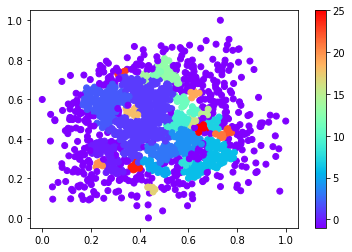

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(pca_df_normalized[0],pca_df_normalized[1], c=labels, cmap='rainbow')
plt.colorbar()

In [ ]:
df_ = pd.read_csv('freq_poids_porter.csv')

In [ ]:
def distance (A,B):
    return np.sqrt(np.sum(np.square(np.subtract(A,B))))

In [ ]:
X = pca_df_normalized.to_numpy()

In [ ]:
X

array([[0.27889606, 0.34738267],
       [0.42599621, 0.6162502 ],
       [0.27233282, 0.24431749],
       ...,
       [0.18835519, 0.28599469],
       [0.31276318, 0.23574628],
       [0.56435643, 0.41612423]])

In [ ]:
#from dbscan import DBSCAN, Plot

In [ ]:

# from sklearn import datasets
# X, y = datasets.make_moons(n_samples=300, noise=0.08, shuffle=False)

In [244]:
class DBSCAN: 
    def __init__(self, eps, min_pts, data):
        self.eps = eps
        self.min_pts = min_pts
        self.data = data
        self.clusters = []
        self.noise = []
        self.core_pts = []
        self.visited = []
        self.clustered = []
        self.cluster_num = 0
        self.clustered_pts = []
        
    def _distance(self, p1, p2):
        result = 0
        for i in range(len(p1)):
            if(type(p1[i]) == str or type(p2[i]) == str):
                if(p1[i] != p2[i]):
                    result += 1
            else : result += (p1[i] - p2[i]) ** 2
        return math.sqrt(result)
        #return math.sqrt(sum([(a - b) ** 2 for a, b in zip(p1, p2)]))
    
    def _region_query(self, point):
        neighbors = []
        for i in range(len(self.data)):
            if self._distance(point, self.data[i]) < self.eps:
                neighbors.append(i)
        return neighbors
    
    def _expand_cluster(self, point, neighbors):
        self.clusters[self.cluster_num].append(point)
        self.clustered.append(point)
        self.visited.append(point)
        for i in neighbors:
            if i not in self.visited:
                self.visited.append(i)
                new_neighbors = self._region_query(self.data[i])
                if len(new_neighbors) >= self.min_pts:
                    neighbors += new_neighbors
            if i not in self.clustered:
                self.clusters[self.cluster_num].append(i)
                self.clustered.append(i)
                
    def fit(self):
        for i in range(len(self.data)):
            if i not in self.visited:
                self.visited.append(i)
                neighbors = self._region_query(self.data[i])
                if len(neighbors) < self.min_pts:
                    self.noise.append(i)
                else:
                    self.clusters.append([])
                    self._expand_cluster(i, neighbors)
                    self.cluster_num += 1
                    
    def get_clusters(self):
        return self.clusters
    
    def get_noise(self):
        return self.noise

    

In [14]:
X = pca_df_normalized.to_numpy()

In [15]:
dbscan = DBSCAN(eps=0.0222221, min_pts=7, data=X)
dbscan.fit()
clusters = dbscan.get_clusters()
noise = dbscan.get_noise()

In [74]:
len(dbscan.get_clusters())

26

In [16]:
pca_df_normalized['label'] = np.nan

In [17]:
pca_df_normalized

0         1  label
0     0.278896  0.347383    NaN
1     0.425996  0.616250    NaN
2     0.272333  0.244317    NaN
3     0.501636  0.798862    NaN
4     0.380549  0.672733    NaN
...        ...       ...    ...
1455  0.333954  0.490487    NaN
1456  0.314208  0.704892    NaN
1457  0.188355  0.285995    NaN
1458  0.312763  0.235746    NaN
1459  0.564356  0.416124    NaN

[1460 rows x 3 columns]

In [18]:
for cluster in range (len(clusters)):
    for element in clusters[cluster]:
        #assign cluster number to each element
        pca_df_normalized.loc[element]['label'] = cluster

In [19]:
for element in noise:
    #assign cluster number to each element
    pca_df_normalized.loc[element]['label'] = -1

In [81]:
pca_df_normalized

0         1  label
0     0.278896  0.347383    0.0
1     0.425996  0.616250   -1.0
2     0.272333  0.244317    0.0
3     0.501636  0.798862   -1.0
4     0.380549  0.672733    1.0
...        ...       ...    ...
1455  0.333954  0.490487    1.0
1456  0.314208  0.704892   -1.0
1457  0.188355  0.285995   -1.0
1458  0.312763  0.235746    0.0
1459  0.564356  0.416124    4.0

[1460 rows x 3 columns]

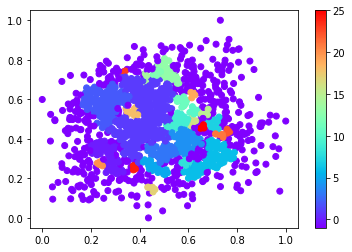

In [82]:
plt.scatter(pca_df_normalized[0],pca_df_normalized[1], c=pca_df_normalized['label'], cmap='rainbow')
plt.colorbar()

In [11]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [85]:
class NaiveBayesClassifier():
    '''
    Bayes Theorem form
    P(y|X) = P(X|y) * P(y) / P(X)
    '''
    def calc_prior(self, features, target):
        '''
        prior probability P(y)
        calculate prior probabilities
        '''
        self.prior = (features.groupby(target).apply(lambda x: len(x)) / self.rows).to_numpy()

        return self.prior
    
    def calc_statistics(self, features, target):
        '''
        calculate mean, variance for each column and convert to numpy array
        ''' 
        self.mean = features.groupby(target).apply(np.mean).to_numpy()
        self.var = features.groupby(target).apply(np.var).to_numpy()
              
        return self.mean, self.var
    
    def gaussian_density(self, class_idx, x):     
        '''
        calculate probability from gaussian density function (normally distributed)
        we will assume that probability of specific target value given specific class is normally distributed 
        
        probability density function derived from wikipedia:
        (1/√2pi*σ) * exp((-1/2)*((x-μ)^2)/(2*σ²)), where μ is mean, σ² is variance, σ is quare root of variance (standard deviation)
        '''
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
#         numerator = np.exp(-((x-mean)**2 / (2 * var)))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob
    
    def calc_posterior(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for i in range(self.count):
            prior = np.log(self.prior[i]) ## use the log to make it more numerically stable
            conditional = np.sum(np.log(self.gaussian_density(i, x))) # use the log to make it more numerically stable
            posterior = prior + conditional
            posteriors.append(posterior)
        # return class with highest posterior probability
        return self.classes[np.argmax(posteriors)]
     

    def fit(self, features, target):
        self.classes = np.unique(target)
        self.count = len(self.classes)
        self.feature_nums = features.shape[1]
        self.rows = features.shape[0]
        
        self.calc_statistics(features, target)
        self.calc_prior(features, target)
        
    def predict(self, features):
        preds = [self.calc_posterior(f) for f in features.to_numpy()]
        return preds

    def accuracy(self, y_test, y_pred):
        accuracy = np.sum(y_test == y_pred) / len(y_test)
        return accuracy

    def visualize(self, y_true, y_pred, target):
        
        tr = pd.DataFrame(data=y_true, columns=[target])
        pr = pd.DataFrame(data=y_pred, columns=[target])
        
        
        fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))
        
        sns.countplot(x=target, data=tr, ax=ax[0], palette='viridis', alpha=0.7, hue=target, dodge=False)
        sns.countplot(x=target, data=pr, ax=ax[1], palette='viridis', alpha=0.7, hue=target, dodge=False)
        

        fig.suptitle('True vs Predicted Comparison', fontsize=20)

        ax[0].tick_params(labelsize=12)
        ax[1].tick_params(labelsize=12)
        ax[0].set_title("True values", fontsize=18)
        ax[1].set_title("Predicted values", fontsize=18)
        plt.show()

In [246]:
import random
def train_test_split(df, test_size):
    # make sure it is a float and get the number of instances in the test set
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))
    # get the indices for the test set
    indices = df.index.tolist()
    # choose them randomly
    test_indices = random.sample(population=indices, k=test_size)
    # separate into test and train
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df.iloc[:,:-1], test_df.iloc[:,:-1], train_df.iloc[:,-1], test_df.iloc[:,-1]

In [23]:
# shuffle dataset with sample
df = pca_df_normalized
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
# df shape
print(df.shape)


# # split on train and test 0.7/0.3
X_train, X_test, y_train, y_test = train_test_split(df, test_size=0.3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1460, 3)
(1022, 2) (1022,)
(438, 2) (438,)


In [102]:
x = NaiveBayesClassifier()


x.fit(X_train, y_train)

In [25]:
x.calc_prior(X_train, y_train)

array([0.34050881, 0.04109589, 0.23972603, 0.10469667, 0.03620352,
       0.04109589, 0.018591  , 0.06262231, 0.00978474, 0.00489237,
       0.02446184, 0.00782779, 0.01174168, 0.00391389, 0.01956947,
       0.00293542, 0.00391389, 0.00195695, 0.00293542, 0.00489237,
       0.00293542, 0.00489237, 0.00293542, 0.00195695, 0.00195695,
       0.00195695])

In [26]:
x.prior

array([0.34050881, 0.04109589, 0.23972603, 0.10469667, 0.03620352,
       0.04109589, 0.018591  , 0.06262231, 0.00978474, 0.00489237,
       0.02446184, 0.00782779, 0.01174168, 0.00391389, 0.01956947,
       0.00293542, 0.00391389, 0.00195695, 0.00293542, 0.00489237,
       0.00293542, 0.00489237, 0.00293542, 0.00195695, 0.00195695,
       0.00195695])

In [27]:
x.calc_statistics(X_train, y_train)

(array([[0.49808395, 0.46691596],
        [0.26765301, 0.31478243],
        [0.42199617, 0.51910015],
        [0.26088486, 0.57791489],
        [0.50105107, 0.33137215],
        [0.58624029, 0.39121139],
        [0.46023942, 0.25811821],
        [0.6895321 , 0.29371014],
        [0.70456937, 0.47663223],
        [0.58646382, 0.27591518],
        [0.55546134, 0.48641636],
        [0.62465337, 0.54344569],
        [0.56998863, 0.59185438],
        [0.46971559, 0.72954646],
        [0.5147906 , 0.7435887 ],
        [0.42571264, 0.7079018 ],
        [0.66526359, 0.53395382],
        [0.61343199, 0.48455553],
        [0.44434721, 0.15173576],
        [0.36290957, 0.53976963],
        [0.61445834, 0.62584766],
        [0.23738901, 0.27282202],
        [0.72277191, 0.41951856],
        [0.33625952, 0.73441195],
        [0.37810332, 0.25606219],
        [0.65614258, 0.46235563]]),
 array([[6.15829324e-02, 4.93427913e-02],
        [9.70190683e-04, 2.43346748e-03],
        [3.94643628e-03, 1.145

In [28]:
x.mean


array([[0.49808395, 0.46691596],
       [0.26765301, 0.31478243],
       [0.42199617, 0.51910015],
       [0.26088486, 0.57791489],
       [0.50105107, 0.33137215],
       [0.58624029, 0.39121139],
       [0.46023942, 0.25811821],
       [0.6895321 , 0.29371014],
       [0.70456937, 0.47663223],
       [0.58646382, 0.27591518],
       [0.55546134, 0.48641636],
       [0.62465337, 0.54344569],
       [0.56998863, 0.59185438],
       [0.46971559, 0.72954646],
       [0.5147906 , 0.7435887 ],
       [0.42571264, 0.7079018 ],
       [0.66526359, 0.53395382],
       [0.61343199, 0.48455553],
       [0.44434721, 0.15173576],
       [0.36290957, 0.53976963],
       [0.61445834, 0.62584766],
       [0.23738901, 0.27282202],
       [0.72277191, 0.41951856],
       [0.33625952, 0.73441195],
       [0.37810332, 0.25606219],
       [0.65614258, 0.46235563]])

In [29]:

predictions = x.predict(X_test)

In [30]:
x.accuracy(y_test, predictions)

0.8264840182648402

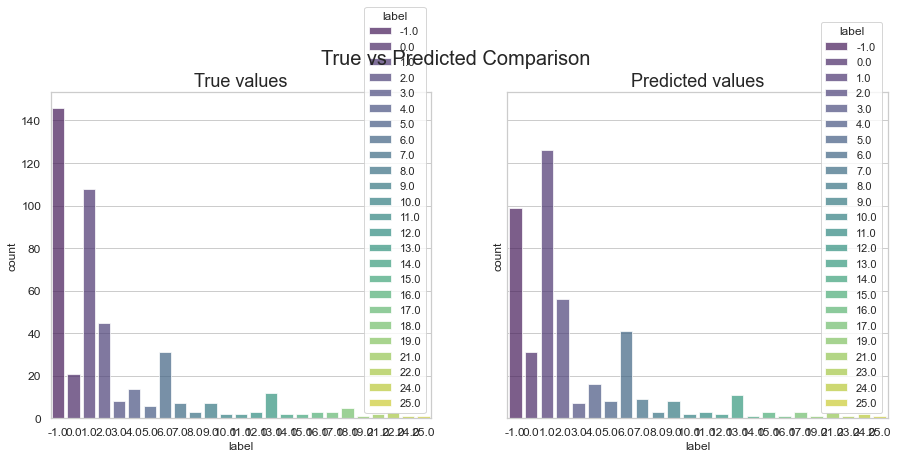

In [31]:
x.visualize(y_test, predictions, 'label')

In [32]:
q1 = qry_set[1]
q1

'What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?'

In [37]:
df_freqs_poids_porter= pd.read_csv('freq_poids_porter.csv')

In [77]:
q1_cosine = Cosine(df_freqs_poids_porter,qry_set[1],'P').sort_values(by='Document',ascending=True).reset_index(drop=True).drop('Document',axis=1).T.values

In [78]:
q1_cosine

array([[0.        , 0.        , 0.        , ..., 0.01362756, 0.05352963,
        0.        ]])

In [84]:
docs = []
for doc in doc_set:
    docs.append(doc)

In [93]:
rows = []
for query in tqdm_notebook(qry_set):
    rows.append(Cosine(df_freqs_poids_porter,qry_set[query],'P').sort_values(by='Document',ascending=True).reset_index(drop=True).drop('Document',axis=1).T.values[0])
queries_porter = pd.DataFrame(rows, columns=docs)

  0%|          | 0/112 [00:00<?, ?it/s]

In [94]:
queries_porter

1         2         3         4         5         6         7     \
0    0.000000  0.000000  0.000000  0.034719  0.015841  0.000000  0.033756   
1    0.000000  0.060536  0.021232  0.011676  0.000000  0.012468  0.000000   
2    0.000000  0.114516  0.032892  0.018089  0.019983  0.019316  0.000000   
3    0.000000  0.000000  0.048315  0.021568  0.012493  0.058748  0.000000   
4    0.022642  0.097363  0.018387  0.090602  0.098100  0.067829  0.013615   
..        ...       ...       ...       ...       ...       ...       ...   
107  0.027135  0.056761  0.046484  0.085061  0.042443  0.078850  0.009643   
108  0.000000  0.086459  0.017845  0.038555  0.035017  0.076359  0.062151   
109  0.023549  0.085921  0.026725  0.037103  0.084834  0.057280  0.000000   
110  0.008577  0.046530  0.020061  0.010784  0.025770  0.041760  0.011974   
111  0.036175  0.060134  0.000000  0.000000  0.040594  0.007757  0.031789   

         8         9         10    ...      1451      1452      1453  \
0    0.030154  0.010675  0.015878  ...  0.020362  0.000000  0.000000   
1    0.019337  0.000000  0.038337  ...  0.000000  0.000000  0.014092   
2    0.000000  0.034179  0.023724  ...  0.000000  0.000000  0.000000   
3    0.000000  0.014292  0.018272  ...  0.000000  0.000000  0.000000   
4    0.027106  0.062214  0.027408  ...  0.000000  0.022183  0.020813   
..        ...       ...       ...  ...       ...       ...       ...   
107  0.025273  0.051200  0.092388  ...  0.016212  0.019680  0.016528   
108  0.019033  0.064343  0.041704  ...  0.024881  0.051251  0.026274   
109  0.005228  0.037298  0.026672  ...  0.012934  0.015769  0.033921   
110  0.000000  0.025786  0.014094  ...  0.000000  0.033713  0.000000   
111  0.016399  0.031212  0.018554  ...  0.011003  0.024364  0.000000   

         1454      1455      1456      1457      1458      1459      1460  
0    0.049391  0.028935  0.000000  0.000000  0.013628  0.053530  0.000000  
1    0.017253  0.000000  0.000000  0.000000  0.000000  0.000000  0.023045  
2    0.000000  0.056292  0.000000  0.029345  0.040071  0.000000  0.035701  
3    0.020958  0.000000  0.000000  0.000000  0.057287  0.000000  0.000000  
4    0.065275  0.037930  0.018812  0.009890  0.012968  0.018224  0.031431  
..        ...       ...       ...       ...       ...       ...       ...  
107  0.046176  0.045845  0.056680  0.019811  0.011761  0.012007  0.026260  
108  0.059513  0.076209  0.047987  0.036424  0.052992  0.010590  0.050259  
109  0.039833  0.048944  0.090060  0.042578  0.019456  0.010065  0.038714  
110  0.028625  0.026477  0.000000  0.012459  0.025897  0.014431  0.033121  
111  0.036983  0.007806  0.000000  0.024521  0.009316  0.025052  0.048563  

[112 rows x 1460 columns]

In [95]:
queries_porter.to_csv('queries_porter.csv', index=False)

In [96]:
pca = PCA(n_components=2)
pca.fit(queries_porter)
x_pca = pca.transform(queries_porter)
pca_df = pd.DataFrame(x_pca)
pca_df
x = pca_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pca_df_normalized = pd.DataFrame(x_scaled)

In [97]:
pca_df_normalized

0         1
0    0.251902  0.436081
1    0.506290  0.519918
2    0.602415  0.977242
3    0.050261  0.640840
4    0.746184  0.563232
..        ...       ...
107  0.680705  0.394505
108  0.426424  0.372978
109  0.389342  0.625601
110  0.365419  0.035030
111  0.175248  0.299125

[112 rows x 2 columns]

In [104]:
pca_df_normalized['label']=x.predict(pca_df_normalized)
   

In [105]:
pca_df_normalized

0         1  label
0    0.251902  0.436081    2.0
1    0.506290  0.519918    1.0
2    0.602415  0.977242   -1.0
3    0.050261  0.640840   -1.0
4    0.746184  0.563232   -1.0
..        ...       ...    ...
107  0.680705  0.394505    6.0
108  0.426424  0.372978    1.0
109  0.389342  0.625601    1.0
110  0.365419  0.035030   -1.0
111  0.175248  0.299125   -1.0

[112 rows x 3 columns]

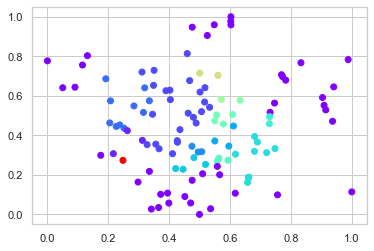

In [106]:
plt.scatter(pca_df_normalized[0], pca_df_normalized[1], c=pca_df_normalized['label'], cmap='rainbow')
plt.show()

In [ ]:
docs = []
for doc in doc_set:
    docs.append(doc)
rows = []
for query in tqdm_notebook(qry_set):
    rows.append(Cosine(df_freqs_poids_porter,qry_set[query],'P').sort_values(by='Document',ascending=True).reset_index(drop=True).drop('Document',axis=1).T.values[0])
queries_porter = pd.DataFrame(rows, columns=docs)

ROC curves

In [12]:
cosine_1 = Cosine(df_freqs_poids_porter,qry_set[1],'P').head(10)
cosine_1

Document  Mesure Cosine
0       315       0.220168
1       429       0.218040
2       447       0.210442
3       722       0.203756
4       449       0.200010
5       565       0.184493
6      1281       0.171043
7      1294       0.167088
8       175       0.166806
9       652       0.161675

In [14]:
cosine_1['Pertinent'] = 'Non'
cosine_1

Document  Mesure Cosine Pertinent
0       315       0.220168       Non
1       429       0.218040       Non
2       447       0.210442       Non
3       722       0.203756       Non
4       449       0.200010       Non
5       565       0.184493       Non
6      1281       0.171043       Non
7      1294       0.167088       Non
8       175       0.166806       Non
9       652       0.161675       Non

In [16]:
cosine_1['Pertinent'] = cosine_1['Document'].apply(lambda x: 'Oui' if x in rel_set[1] else 'Non')

In [17]:
cosine_1

Document  Mesure Cosine Pertinent
0       315       0.220168       Non
1       429       0.218040       Oui
2       447       0.210442       Non
3       722       0.203756       Oui
4       449       0.200010       Non
5       565       0.184493       Non
6      1281       0.171043       Oui
7      1294       0.167088       Non
8       175       0.166806       Non
9       652       0.161675       Non

In [29]:
cosine_1['Precision'] = 0.0
cosine_1['Rappel'] = 0.0

In [30]:
c=0
p=cosine_1['Pertinent'].value_counts()['Oui']
for i in range (0,10):
    if cosine_1['Pertinent'][i] == 'Oui':
        c+=1
    cosine_1['Precision'][i] = c/(i+1)
    cosine_1['Rappel'][i] = c/p


In [31]:
cosine_1

Document  Mesure Cosine Pertinent  Precision    Rappel
0       315       0.220168       Non   0.000000  0.000000
1       429       0.218040       Oui   0.500000  0.333333
2       447       0.210442       Non   0.333333  0.333333
3       722       0.203756       Oui   0.500000  0.666667
4       449       0.200010       Non   0.400000  0.666667
5       565       0.184493       Non   0.333333  0.666667
6      1281       0.171043       Oui   0.428571  1.000000
7      1294       0.167088       Non   0.375000  1.000000
8       175       0.166806       Non   0.333333  1.000000
9       652       0.161675       Non   0.300000  1.000000

In [40]:
cosine_1['Precision_Interpolée'] = 0.0
cosine_1['Rappel_Interpolée'] = 0.0
for i in range (0,10):
    cosine_1['Rappel_Interpolée'][i]=i/10
    cos= cosine_1[cosine_1['Rappel_Interpolée'][i] <= cosine_1['Rappel']]
    if cos.empty:
        cosine_1['Precision_Interpolée'][i]=0
    else:
        cosine_1['Precision_Interpolée'][i]=cos['Precision'].max()


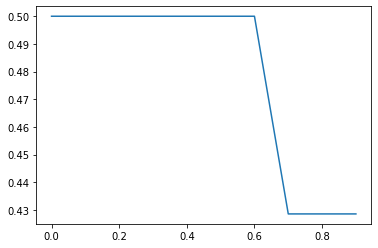

In [41]:
plt.plot(cosine_1['Rappel_Interpolée'],cosine_1['Precision_Interpolée'])

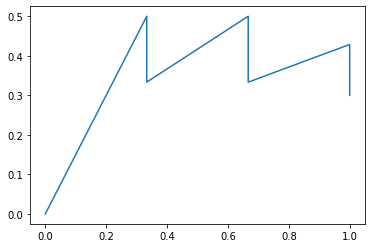

In [42]:
import matplotlib.pyplot as plt
plt.plot(cosine_1['Rappel'],cosine_1['Precision'])

In [75]:
def _distance(p1, p2):
        result = 0
        for i in range(len(p1)):
            if(type(p1[i]) == str or type(p2[i]) == str):
                if(p1[i] != p2[i]):
                    result += 1
            else : result += (p1[i] - p2[i]) ** 2
        return math.sqrt(result)

In [285]:

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn import preprocessing
def roc_curve(stemmer,query,measure):
    df_freqs_poids_porter= pd.read_csv('freq_poids_porter.csv')
    df_freqs_poids_lan= pd.read_csv('freq_poids_lancaster.csv')
    if measure=='Datamining':
        X_train = pd.read_csv('X_train.csv')
        y_train = pd.read_csv('y_train.csv')
        X_test = pd.read_csv('X_test.csv')
        y_test = pd.read_csv('y_test.csv')
        bayes= NaiveBayesClassifier()
        bayes.fit(X_train.squeeze(), y_train.squeeze())
        queries_porter = pd.read_csv('queries_porter.csv')
        pca = PCA(n_components=2)
        pca.fit(queries_porter)
        x_pca = pca.transform(queries_porter)
        pca_df = pd.DataFrame(x_pca)
        pca_df
        x = pca_df.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        pca_df_normalized_queries = pd.DataFrame(x_scaled)
        pca_df_normalized_queries['label']=bayes.predict(pca_df_normalized_queries)
        pca_df_dbscan = pd.read_csv('pca_df_dbscan.csv').drop(columns=['Unnamed: 0'])
        docs = pca_df_dbscan[pca_df_dbscan['label'] == pca_df_normalized_queries.loc[query-1]['label']]
        docs['Document']=docs.index+1
        docs['Distance']=np.nan
        cols = ['doc','distance']
        for doc in docs.index+1:
            docs['Distance'].loc[doc-1] = _distance(pca_df_normalized_queries.loc[query-1,0:1],docs.loc[doc-1][0:2].values)
                #r = r.append({'doc':doc,'distance':_distance(pca_df_normalized_queries.loc[qry-1,0:1],p.loc[doc-1,0:1])}, ignore_index=True)
        docs = docs.sort_values(by=['Distance'], ascending=True).head(10)
        docs['Pertinent']= docs['Document'].apply(lambda x: 'Oui' if x in rel_set[query] else 'Non')
        docs['Precision']=0.0
        docs['Rappel']=0.0
        docs['F-Mesure']=0.0
        docs['Precision_Interpolée']=0.0
        docs['Rappel_Interpolée']=0.0
        docs['F-Mesure_Interpolée']=0.0
        c=0
        try:
            p=docs['Pertinent'].value_counts()['Oui']
        except:
            p=0
        
        for i in range(0,10):
            if docs['Pertinent'].iloc[i] == 'Oui':
                c+=1
            docs['Precision'].iloc[i] = c/(i+1)
            try:
                docs['Rappel'].iloc[i] = c/p
            except:
                docs['Rappel'].iloc[i] = 0
            docs['F-Mesure'].iloc[i] = 2*docs['Precision'].iloc[i]*docs['Rappel'].iloc[i]/(docs['Precision'].iloc[i]+docs['Rappel'].iloc[i])
        docs['Precision_Interpolée'] = 0.0
        docs['Rappel_Interpolée'] = 0.0
        docs['F-Mesure_Interpolée'] = 0.0
        k=0
        for i in range(0,10):
            docs['Rappel_Interpolée'].iloc[i]=k/10
            jac= docs[docs['Rappel_Interpolée'].iloc[i] <= docs['Rappel']]
            if jac.empty:
                docs['Precision_Interpolée'].iloc[i]=0
            else:
                docs['Precision_Interpolée'].iloc[i]=jac['Precision'].max()
            docs['F-Mesure_Interpolée'].iloc[i] = 2*docs['Precision_Interpolée'].iloc[i]*docs['Rappel_Interpolée'].iloc[i]/(docs['Precision_Interpolée'].iloc[i]+docs['Rappel_Interpolée'].iloc[i])
            k+=1
        return docs        
    if stemmer=='P':
        if measure=='Produit Scalaire':
            produit = produit_scalaire(df_freqs_poids_porter,qry_set[query],'P')[1].sort_values(by='Poid',ascending=False).reset_index(drop=True).head(10)
            produit['Pertinent'] = produit['Document'].apply(lambda x: 'Oui' if x in rel_set[query] else 'Non')
            produit['Precision'] = 0.0
            produit['Rappel'] = 0.0
            produit['F-measure'] = 0.0
            c=0
            try:
                p=produit['Pertinent'].value_counts()['Oui']
            except:
                p=0
            for i in range (0,10):
                if produit['Pertinent'].iloc[i] == 'Oui':
                    c+=1
                produit['Precision'].iloc[i] = c/(i+1)
                try:
                    produit['Rappel'].iloc[i] = c/p
                except:
                    produit['Rappel'].iloc[i] = 0
                produit['F-measure'].iloc[i] = 2*produit['Precision'].iloc[i]*produit['Rappel'].iloc[i]/(produit['Precision'].iloc[i]+produit['Rappel'].iloc[i])
            produit['Precision_Interpolée'] = 0.0
            produit['Rappel_Interpolée'] = 0.0
            produit['F-measure_Interpolée'] = 0.0
            for i in range (0,10):
                produit['Rappel_Interpolée'].iloc[i]=i/10
                cos= produit[produit['Rappel_Interpolée'].iloc[i] <= produit['Rappel']]
                if cos.empty:
                    produit['Precision_Interpolée'].iloc[i]=0
                else:
                    produit['Precision_Interpolée'].iloc[i]=cos['Precision'].max()
                produit['F-measure_Interpolée'].iloc[i]=2*produit['Precision_Interpolée'].iloc[i]*produit['Rappel_Interpolée'].iloc[i]/(produit['Precision_Interpolée'].iloc[i]+produit['Rappel_Interpolée'].iloc[i])
                
            return produit
        elif measure == 'Cosine':
            cosine = Cosine(df_freqs_poids_porter,qry_set[query],'P').head(10)
            cosine['Pertinent'] = cosine['Document'].apply(lambda x: 'Oui' if x in rel_set[query] else 'Non')
            cosine['Precision'] = 0.0
            cosine['Rappel'] = 0.0
            cosine['F-measure'] = 0.0
            c=0
            try:
                p=cosine['Pertinent'].value_counts()['Oui']
            except:
                p=0
            for i in range (0,10):
                if cosine['Pertinent'].iloc[i] == 'Oui':
                    c+=1
                cosine['Precision'].iloc[i] = c/(i+1)
                try:
                    cosine['Rappel'].iloc[i] = c/p
                except:
                    cosine['Rappel'].iloc[i] = 0
                cosine['F-measure'].iloc[i] = 2*cosine['Precision'].iloc[i]*cosine['Rappel'].iloc[i]/(cosine['Precision'].iloc[i]+cosine['Rappel'].iloc[i])
            cosine['Precision_Interpolée'] = 0.0
            cosine['Rappel_Interpolée'] = 0.0
            cosine['F-measure_Interpolée'] = 0.0
            for i in range (0,10):
                cosine['Rappel_Interpolée'].iloc[i]=i/10
                cos= cosine[cosine['Rappel_Interpolée'].iloc[i] <= cosine['Rappel']]
                if cos.empty:
                    cosine['Precision_Interpolée'].iloc[i]=0
                else:
                    cosine['Precision_Interpolée'].iloc[i]=cos['Precision'].max()
                cosine['F-measure_Interpolée'].iloc[i]=2*cosine['Precision_Interpolée'].iloc[i]*cosine['Rappel_Interpolée'].iloc[i]/(cosine['Precision_Interpolée'].iloc[i]+cosine['Rappel_Interpolée'].iloc[i])
            return cosine
        elif measure == 'Jaccard':
            jaccard = Jaccard(df_freqs_poids_porter,qry_set[query],'P').head(10)
            jaccard['Pertinent'] = jaccard['Document'].apply(lambda x: 'Oui' if x in rel_set[query] else 'Non')
            jaccard['Precision'] = 0.0
            jaccard['Rappel'] = 0.0
            jaccard['F-measure'] = 0.0
            c=0
            try:
                p=jaccard['Pertinent'].value_counts()['Oui']
            except:
                p=0
            for i in range (0,10):
                if jaccard['Pertinent'].iloc[i] == 'Oui':
                    c+=1
                jaccard['Precision'].iloc[i] = c/(i+1)
                try:
                    jaccard['Rappel'].iloc[i] = c/p
                except:
                    jaccard['Rappel'].iloc[i] = 0
                jaccard['F-measure'].iloc[i] = 2*jaccard['Precision'].iloc[i]*jaccard['Rappel'].iloc[i]/(jaccard['Precision'].iloc[i]+jaccard['Rappel'].iloc[i])
            jaccard['Precision_Interpolée'] = 0.0
            jaccard['Rappel_Interpolée'] = 0.0
            jaccard['F-measure_Interpolée'] = 0.0
            for i in range (0,10):
                jaccard['Rappel_Interpolée'].iloc[i]=i/10
                jac= jaccard[jaccard['Rappel_Interpolée'].iloc[i] <= jaccard['Rappel']]
                if jac.empty:
                    jaccard['Precision_Interpolée'].iloc[i]=0
                else:
                    jaccard['Precision_Interpolée'].iloc[i]=jac['Precision'].max()
                jaccard['F-measure_Interpolée'].iloc[i]=2*jaccard['Precision_Interpolée'].iloc[i]*jaccard['Rappel_Interpolée'].iloc[i]/(jaccard['Precision_Interpolée'].iloc[i]+jaccard['Rappel_Interpolée'].iloc[i])
            return jaccard
        elif measure== 'BM25':
            bm25 = BM25(df_freqs_poids_porter,qry_set[query],'P').head(10)
            bm25['Pertinent'] = bm25['Document'].apply(lambda x: 'Oui' if x in rel_set[query] else 'Non')
            bm25['Precision'] = 0.0
            bm25['Rappel'] = 0.0
            bm25['F-measure'] = 0.0
            c=0
            try:
                p=bm25['Pertinent'].value_counts()['Oui']
            except:
                p=0
            for i in range (0,10):
                if bm25['Pertinent'].iloc[i] == 'Oui':
                    c+=1
                bm25['Precision'].iloc[i] = c/(i+1)
                try:
                    bm25['Rappel'].iloc[i] = c/p
                except:
                    bm25['Rappel'].iloc[i] = 0
                bm25['F-measure'].iloc[i] = 2*bm25['Precision'].iloc[i]*bm25['Rappel'].iloc[i]/(bm25['Precision'].iloc[i]+bm25['Rappel'].iloc[i])
            bm25['Precision_Interpolée'] = 0.0
            bm25['Rappel_Interpolée'] = 0.0
            bm25['F-measure_Interpolée'] = 0.0
            for i in range (0,10):
                bm25['Rappel_Interpolée'].iloc[i]=i/10
                bm= bm25[bm25['Rappel_Interpolée'].iloc[i] <= bm25['Rappel']]
                if bm.empty:
                    bm25['Precision_Interpolée'].iloc[i]=0
                else:
                    bm25['Precision_Interpolée'].iloc[i]=bm['Precision'].max()
                bm25['F-measure_Interpolée'].iloc[i]=2*bm25['Precision_Interpolée'].iloc[i]*bm25['Rappel_Interpolée'].iloc[i]/(bm25['Precision_Interpolée'].iloc[i]+bm25['Rappel_Interpolée'].iloc[i])
            return bm25
        else :
            print('Erreur de mesure')
    elif stemmer=='L':
        if measure=='Produit Scalaire':
            produit = produit_scalaire(df_freqs_poids_lan,qry_set[query],'L')[1].sort_values(by='Poid',ascending=False).reset_index(drop=True).head(10)
            produit['Pertinent'] = produit['Document'].apply(lambda x: 'Oui' if x in rel_set[query] else 'Non')
            produit['Precision'] = 0.0
            produit['Rappel'] = 0.0
            produit['F-measure'] = 0.0
            c=0
            try:
                p=produit['Pertinent'].value_counts()['Oui']
            except:
                p=0
            for i in range (0,10):
                if produit['Pertinent'].iloc[i] == 'Oui':
                    c+=1
                produit['Precision'].iloc[i] = c/(i+1)
                produit['Rappel'].iloc[i] = c/p
                produit['F-measure'].iloc[i] = 2*produit['Precision'].iloc[i]*produit['Rappel'].iloc[i]/(produit['Precision'].iloc[i]+produit['Rappel'].iloc[i])
            produit['Precision_Interpolée'] = 0.0
            produit['Rappel_Interpolée'] = 0.0
            produit['F-measure_Interpolée'] = 0.0
            for i in range (0,10):
                produit['Rappel_Interpolée'].iloc[i]=i/10
                cos= produit[produit['Rappel_Interpolée'].iloc[i] <= produit['Rappel']]
                if cos.empty:
                    produit['Precision_Interpolée'].iloc[i]=0
                else:
                    produit['Precision_Interpolée'].iloc[i]=cos['Precision'].max()
                produit['F-measure_Interpolée'].iloc[i]=2*produit['Precision_Interpolée'].iloc[i]*produit['Rappel_Interpolée'].iloc[i]/(produit['Precision_Interpolée'].iloc[i]+produit['Rappel_Interpolée'].iloc[i])
                return produit
        elif measure=='Cosine':
            cosine = Cosine(df_freqs_poids_lan,qry_set[query],'L').head(10)
            cosine['Pertinent'] = cosine['Document'].apply(lambda x: 'Oui' if x in rel_set[query] else 'Non')
            cosine['Precision'] = 0.0
            cosine['Rappel'] = 0.0
            cosine['F-measure'] = 0.0
            c=0
            try:
                p=cosine['Pertinent'].value_counts()['Oui']
            except:
                p=0
            for i in range (0,10):
                if cosine['Pertinent'].iloc[i] == 'Oui':
                    c+=1
                cosine['Precision'].iloc[i] = c/(i+1)
                try:
                    cosine['Rappel'].iloc[i] = c/p
                except:
                    cosine['Rappel'].iloc[i] = 0
                cosine['F-measure'].iloc[i] = 2*cosine['Precision'].iloc[i]*cosine['Rappel'].iloc[i]/(cosine['Precision'].iloc[i]+cosine['Rappel'].iloc[i])
            cosine['Precision_Interpolée'] = 0.0
            cosine['Rappel_Interpolée'] = 0.0
            cosine['F-measure_Interpolée'] = 0.0
            for i in range (0,10):
                cosine['Rappel_Interpolée'].iloc[i]=i/10
                cos= cosine[cosine['Rappel_Interpolée'].iloc[i] <= cosine['Rappel']]
                if cos.empty:
                    cosine['Precision_Interpolée'].iloc[i]=0
                else:
                    cosine['Precision_Interpolée'].iloc[i]=cos['Precision'].max()
                cosine['F-measure_Interpolée'].iloc[i]=2*cosine['Precision_Interpolée'].iloc[i]*cosine['Rappel_Interpolée'].iloc[i]/(cosine['Precision_Interpolée'].iloc[i]+cosine['Rappel_Interpolée'].iloc[i])
            return cosine
        elif measure == 'Jaccard':
            jaccard = Jaccard(df_freqs_poids_lan,qry_set[query],'L').head(10)
            jaccard['Pertinent'] = jaccard['Document'].apply(lambda x: 'Oui' if x in rel_set[query] else 'Non')
            jaccard['Precision'] = 0.0
            jaccard['Rappel'] = 0.0
            jaccard['F-measure'] = 0.0
            c=0
            try:
                p=jaccard['Pertinent'].value_counts()['Oui']
            except:
                p=0
            for i in range (0,10):
                if jaccard['Pertinent'].iloc[i] == 'Oui':
                    c+=1
                jaccard['Precision'].iloc[i] = c/(i+1)
                try:
                    jaccard['Rappel'].iloc[i] = c/p
                except:
                    jaccard['Rappel'].iloc[i] = 0
                jaccard['F-measure'].iloc[i] = 2*jaccard['Precision'].iloc[i]*jaccard['Rappel'].iloc[i]/(jaccard['Precision'].iloc[i]+jaccard['Rappel'].iloc[i])
            jaccard['Precision_Interpolée'] = 0.0
            jaccard['Rappel_Interpolée'] = 0.0
            jaccard['F-measure_Interpolée'] = 0.0
            for i in range (0,10):
                jaccard['Rappel_Interpolée'][i]=i/10
                jac= jaccard[jaccard['Rappel_Interpolée'].iloc[i] <= jaccard['Rappel']]
                if jac.empty:
                    jaccard['Precision_Interpolée'].iloc[i]=0
                else:
                    jaccard['Precision_Interpolée'].iloc[i]=jac['Precision'].max()
                jaccard['F-measure_Interpolée'].iloc[i]=2*jaccard['Precision_Interpolée'].iloc[i]*jaccard['Rappel_Interpolée'].iloc[i]/(jaccard['Precision_Interpolée'].iloc[i]+jaccard['Rappel_Interpolée'].iloc[i])
            return jaccard
        elif measure== 'BM25':
            bm25 = BM25(df_freqs_poids_lan,qry_set[query],'L').head(10)
            bm25['Pertinent'] = bm25['Document'].apply(lambda x: 'Oui' if x in rel_set[query] else 'Non')
            bm25['Precision'] = 0.0
            bm25['Rappel'] = 0.0
            bm25['F-measure'] = 0.0
            c=0
            try:
                p=bm25['Pertinent'].value_counts()['Oui']
            except:
                p=0
            for i in range (0,10):
                if bm25['Pertinent'].iloc[i] == 'Oui':
                    c+=1
                bm25['Precision'].iloc[i] = c/(i+1)
                try:
                    bm25['Rappel'].iloc[i] = c/p
                except:
                    bm25['Rappel'].iloc[i] = 0
                bm25['F-measure'].iloc[i] = 2*bm25['Precision'].iloc[i]*bm25['Rappel'].iloc[i]/(bm25['Precision'].iloc[i]+bm25['Rappel'].iloc[i])
            bm25['Precision_Interpolée'] = 0.0
            bm25['Rappel_Interpolée'] = 0.0
            bm25['F-measure_Interpolée'] = 0.0
            for i in range (0,10):
                bm25['Rappel_Interpolée'].iloc[i]=i/10
                bm= bm25[bm25['Rappel_Interpolée'].iloc[i] <= bm25['Rappel']]
                if bm.empty:
                    bm25['Precision_Interpolée'].iloc[i]=0
                else:
                    bm25['Precision_Interpolée'].iloc[i]=bm['Precision'].max()
                bm25['F-measure_Interpolée'].iloc[i]=2*bm25['Precision_Interpolée'].iloc[i]*bm25['Rappel_Interpolée'].iloc[i]/(bm25['Precision_Interpolée'].iloc[i]+bm25['Rappel_Interpolée'].iloc[i])
            return bm25
        else : 
            print('Erreur de mesure')
    else : 
        print('Erreur de stemmer')


P@5 :  0.6
P@10 :  0.5
P@5 interpolée :  0.625
P@10 interpolée :  0.625


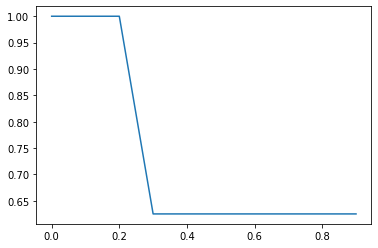

In [288]:
res = roc_curve('P',27,'Cosine')
print('P@5 : ',res['Precision'].iloc[4])
print('P@10 : ',res['Precision'].iloc[9])
print('P@5 interpolée : ',res['Precision_Interpolée'].iloc[4])
print('P@10 interpolée : ',res['Precision_Interpolée'].iloc[9])
import matplotlib.pyplot as plt
plt.plot(res['Rappel_Interpolée'],res['Precision_Interpolée'])

P@5 :  0.4
P@10 :  0.5
P@5 interpolée :  0.5714285714285714
P@10 interpolée :  0.5555555555555556


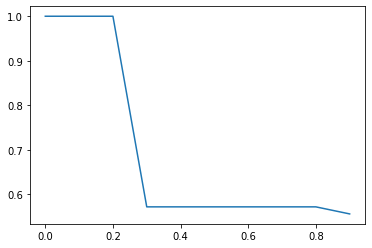

In [289]:
res = roc_curve('P',27,'Jaccard')
print('P@5 : ',res['Precision'].iloc[4])
print('P@10 : ',res['Precision'].iloc[9])
print('P@5 interpolée : ',res['Precision_Interpolée'].iloc[4])
print('P@10 interpolée : ',res['Precision_Interpolée'].iloc[9])
plt.plot(res['Rappel_Interpolée'],res['Precision_Interpolée'])

P@5 :  0.2
P@10 :  0.3
P@5 interpolée :  0.3333333333333333
P@10 interpolée :  0.3


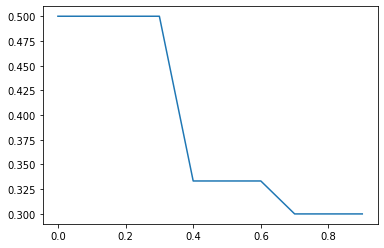

In [290]:
res = roc_curve('P',27,'BM25')
print('P@5 : ',res['Precision'].iloc[4])
print('P@10 : ',res['Precision'].iloc[9])
print('P@5 interpolée : ',res['Precision_Interpolée'].iloc[4])
print('P@10 interpolée : ',res['Precision_Interpolée'].iloc[9])
plt.plot(res['Rappel_Interpolée'],res['Precision_Interpolée'])

P@5 :  0.6
P@10 :  0.6
P@5 interpolée :  0.75
P@10 interpolée :  0.75


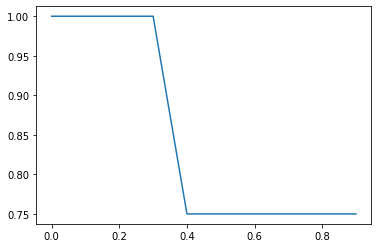

In [291]:
res= roc_curve('P',27,'Produit Scalaire')
print('P@5 : ',res['Precision'].iloc[4])
print('P@10 : ',res['Precision'].iloc[9])
print('P@5 interpolée : ',res['Precision_Interpolée'].iloc[4])
print('P@10 interpolée : ',res['Precision_Interpolée'].iloc[9])
plt.plot(res['Rappel_Interpolée'],res['Precision_Interpolée'])

P@5 :  0.8
P@10 :  0.8
P@5 interpolée :  1.0
P@10 interpolée :  0.8


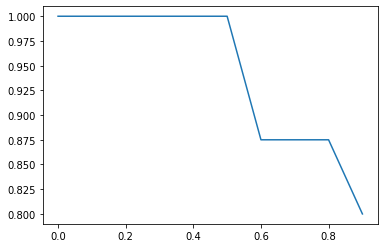

In [292]:
res = roc_curve('P',27,'Datamining')
print('P@5 : ',res['Precision'].iloc[4])
print('P@10 : ',res['Precision'].iloc[9])
print('P@5 interpolée : ',res['Precision_Interpolée'].iloc[4])
print('P@10 interpolée : ',res['Precision_Interpolée'].iloc[9])
plt.plot(res['Rappel_Interpolée'],res['Precision_Interpolée'])


In [234]:
res

0         1  label  Document Pertinent  Precision  Rappel  \
16    0.731445  1.000000   -1.0        17       Non   0.000000     0.0   
139   0.585235  0.843735   -1.0       140       Oui   0.007092     1.0   
294   0.572024  0.852668   -1.0       295       Non   0.003378     1.0   
407   0.650653  0.858373   -1.0       408       Non   0.002445     1.0   
838   0.673196  0.897046   -1.0       839       Non   0.001190     1.0   
841   0.713798  0.878744   -1.0       842       Non   0.001186     1.0   
945   0.533132  0.863400   -1.0       946       Non   0.001056     1.0   
947   0.566710  0.861421   -1.0       948       Non   0.001054     1.0   
1317  0.488056  0.870834   -1.0      1318       Non   0.000758     1.0   
1348  0.605093  0.874108   -1.0      1349       Non   0.000741     1.0   

      F-Mesure  Precision_Interpolée  Rappel_Interpolée  F-Mesure_Interpolée  
16         NaN              0.007092                0.0             0.000000  
139   0.014085              0.007092                0.1             0.013245  
294   0.006734              0.007092                0.2             0.013699  
407   0.004878              0.007092                0.3             0.013857  
838   0.002378              0.007092                0.4             0.013937  
841   0.002370              0.007092                0.5             0.013986  
945   0.002110              0.007092                0.6             0.014019  
947   0.002105              0.007092                0.7             0.014042  
1317  0.001515              0.007092                0.8             0.014060  
1348  0.001480              0.007092                0.9             0.014073

In [9]:
df = pd.read_csv('distances.csv')
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df)
x_pca = pca.transform(df)
pca_df = pd.DataFrame(x_pca)
pca_df
from sklearn import preprocessing

x = pca_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pca_df_normalized = pd.DataFrame(x_scaled)
X = pca_df_normalized.to_numpy()
dbscan = DBSCAN(eps=0.0222221, min_pts=7, data=X)
dbscan.fit()
clusters = dbscan.get_clusters()
noise = dbscan.get_noise()
pca_df_normalized['label'] = np.nan
for cluster in range (len(clusters)):
    for element in clusters[cluster]:
        #assign cluster number to each element
        pca_df_normalized.loc[element]['label'] = cluster
for element in noise:
    #assign cluster number to each element
    pca_df_normalized.loc[element]['label'] = -1
pca_df_normalized

0         1  label
0     0.278896  0.347383    0.0
1     0.425996  0.616250   -1.0
2     0.272333  0.244317    0.0
3     0.501636  0.798862   -1.0
4     0.380549  0.672733    1.0
...        ...       ...    ...
1455  0.333954  0.490487    1.0
1456  0.314208  0.704892   -1.0
1457  0.188355  0.285995   -1.0
1458  0.312763  0.235746    0.0
1459  0.564356  0.416124    4.0

[1460 rows x 3 columns]

In [122]:
pca_df_normalized.to_csv('pca_df_dbscan.csv')

In [139]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
df = pca_df_normalized
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
# df shape
print(df.shape)


# # split on train and test 0.7/0.3
X_train, X_test, y_train, y_test = train_test_split(df, test_size=0.3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
bayes = NaiveBayesClassifier()


bayes.fit(X_train, y_train)

(1460, 3)
(1022, 2) (1022,)
(438, 2) (438,)


In [140]:
X_train

0         1
1     0.414595  0.850676
4     0.254973  0.178523
5     0.500984  0.367165
6     0.105105  0.426345
7     0.252420  0.505431
...        ...       ...
1455  0.655567  0.377292
1456  0.236657  0.640192
1457  0.280930  0.294035
1458  0.203872  0.327931
1459  0.343107  0.431656

[1022 rows x 2 columns]

In [116]:
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

In [117]:
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

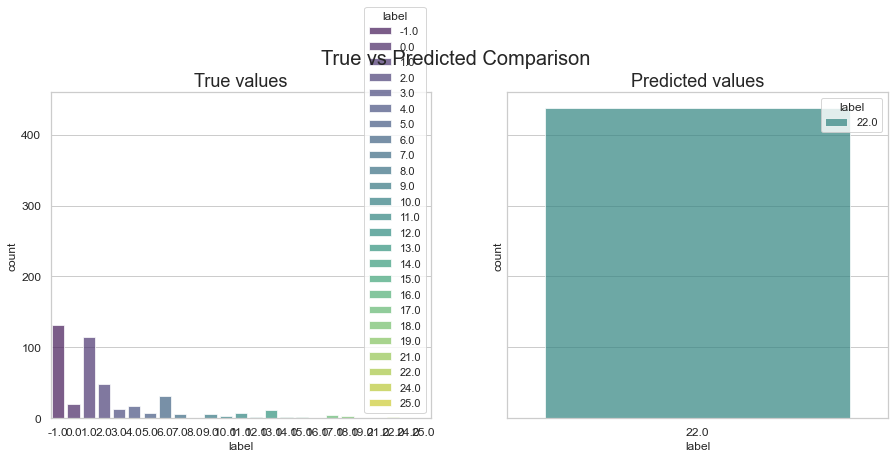

In [136]:
predictions = bayes.predict(X_test)
bayes.visualize(y_test, predictions, 'label')

In [130]:
bayes.accuracy(y_test, predictions)

0.7922374429223744

In [113]:
queries_porter = pd.read_csv('queries_porter.csv')
pca = PCA(n_components=2)
pca.fit(queries_porter)
x_pca = pca.transform(queries_porter)
pca_df = pd.DataFrame(x_pca)
pca_df
x = pca_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pca_df_normalized_queries = pd.DataFrame(x_scaled)
pca_df_normalized_queries['label']=bayes.predict(pca_df_normalized_queries)
pca_df_normalized_queries

0         1  label
0    0.251902  0.436081    0.0
1    0.506290  0.519918    1.0
2    0.602415  0.977242   -1.0
3    0.050261  0.640840   -1.0
4    0.746184  0.563232   -1.0
..        ...       ...    ...
107  0.680705  0.394505    6.0
108  0.426424  0.372978    1.0
109  0.389342  0.625601    1.0
110  0.365419  0.035030   -1.0
111  0.175248  0.299125   -1.0

[112 rows x 3 columns]

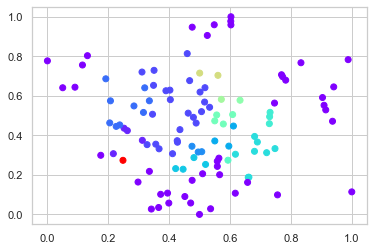

In [114]:
plt.scatter(pca_df_normalized_queries[0], pca_df_normalized_queries[1], c=pca_df_normalized_queries['label'], cmap='rainbow')

In [123]:
X_train

0         1
0     0.636881  0.358213
1     0.414595  0.850676
2     0.043103  0.094810
3     0.105105  0.426345
4     0.346056  0.368793
...        ...       ...
1017  0.366060  0.705227
1018  0.555263  0.589924
1019  0.236657  0.640192
1020  0.280930  0.294035
1021  0.343107  0.431656

[1022 rows x 2 columns]

In [124]:
y_train

label
0      -1.0
1      -1.0
2      -1.0
3      -1.0
4       1.0
...     ...
1017    1.0
1018   11.0
1019    2.0
1020    0.0
1021    1.0

[1022 rows x 1 columns]

In [180]:

X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')
bayes= NaiveBayesClassifier()
bayes.fit(X_train.squeeze(), y_train.squeeze())
queries_porter = pd.read_csv('queries_porter.csv')
pca = PCA(n_components=2)
pca.fit(queries_porter)
x_pca = pca.transform(queries_porter)
pca_df = pd.DataFrame(x_pca)
pca_df
x = pca_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pca_df_normalized_queries = pd.DataFrame(x_scaled)
pca_df_normalized_queries['label']=bayes.predict(pca_df_normalized_queries)
clusters = pd.concat([X_train, y_train], axis=1)
pca_df_dbscan = pd.read_csv('pca_df_dbscan.csv').drop(columns=['Unnamed: 0'])
docs = pca_df_dbscan[pca_df_dbscan['label'] == pca_df_normalized_queries.loc[0]['label']].head(10)
docs['Document']=docs.index+1
docs['Pertinent']= docs['Document'].apply(lambda x: 'Oui' if x in rel_set[1] else 'Non')
docs['Precision']=0.0
docs['Rappel']=0.0
docs['F-Mesure']=0.0
docs['Precision_Interpolée']=0.0
docs['Rappel_Interpolée']=0.0
docs['F-Mesure_Interpolée']=0.0
c=0
try:
    p=docs['Pertinent'].value_counts()['Oui']
except:
    p=0
print(p)
for i in docs['Document']:
    if docs['Pertinent'][i-1] == 'Oui':
        c+=1
    docs['Precision'][i-1] = c/(i+1)
    try:
        docs['Rappel'][i-1] = c/p
    except:
        docs['Rappel'][i-1] = 0
docs['Precision_Interpolée'] = 0.0
docs['Rappel_Interpolée'] = 0.0
k=0
for i in docs['Document']:
    docs['Rappel_Interpolée'][i-1]=k/10
    jac= docs[docs['Rappel_Interpolée'][i-1] <= docs['Rappel']]
    if jac.empty:
        docs['Precision_Interpolée'][i-1]=0
    else:
        docs['Precision_Interpolée'][i-1]=jac['Precision'].max()
    k+=1

0


In [181]:
docs

0         1  label  Document Pertinent  Precision  Rappel  \
0    0.278896  0.347383    0.0         1       Non        0.0     0.0   
2    0.272333  0.244317    0.0         3       Non        0.0     0.0   
39   0.292274  0.314434    0.0        40       Non        0.0     0.0   
87   0.292198  0.337916    0.0        88       Non        0.0     0.0   
99   0.221000  0.377110    0.0       100       Non        0.0     0.0   
100  0.240212  0.387449    0.0       101       Non        0.0     0.0   
102  0.231052  0.375869    0.0       103       Non        0.0     0.0   
107  0.219387  0.348284    0.0       108       Non        0.0     0.0   
109  0.289988  0.291612    0.0       110       Non        0.0     0.0   
143  0.224965  0.318954    0.0       144       Non        0.0     0.0   

     F-Mesure  Precision_Interpolée  Rappel_Interpolée  F-Mesure_Interpolée  
0         0.0                   0.0                0.0                  0.0  
2         0.0                   0.0                0.1                  0.0  
39        0.0                   0.0                0.2                  0.0  
87        0.0                   0.0                0.3                  0.0  
99        0.0                   0.0                0.4                  0.0  
100       0.0                   0.0                0.5                  0.0  
102       0.0                   0.0                0.6                  0.0  
107       0.0                   0.0                0.7                  0.0  
109       0.0                   0.0                0.8                  0.0  
143       0.0                   0.0                0.9                  0.0

In [151]:
pca_df_normalized_queries.loc[0]

0        0.251902
1        0.436081
label    0.000000
Name: 0, dtype: float64

In [18]:
def accuracy(matrix):
    return (matrix[0][0]+matrix[1][1])/np.sum(matrix)
def precision(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[1][0])
def rappel(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[0][1])
def f1_score(matrix):
    return 2*precision(matrix)*rappel(matrix)/(precision(matrix)+rappel(matrix))
def specificity(matrix):
    return matrix[1][1]/(matrix[1][1]+matrix[0][1])
def sensitivity(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[1][0])

In [69]:
def _distance(p1, p2):
        result = 0
        for i in range(len(p1)):
            if(type(p1[i]) == str or type(p2[i]) == str):
                if(p1[i] != p2[i]):
                    result += 1
            else : result += (p1[i] - p2[i]) ** 2
        return math.sqrt(result)

In [263]:
df = pd.read_csv('distances.csv')
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df)
x_pca = pca.transform(df)
pca_df = pd.DataFrame(x_pca)
pca_df
from sklearn import preprocessing
x = pca_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pca_df_normalized = pd.DataFrame(x_scaled)
X = pca_df_normalized.to_numpy()
eps = [0.01,0.02, 0.0222221, 0.03, 0.04, 0.05, 0.1 , 0.5, 1]
min_pts = [5,7,10,15,25,50]
cols = ['eps', 'min_pts','clusters','Bayes accuracy','P@5','P@10', 'accuracy', 'precision', 'rappel', 'f1_score', 'specificity', 'sensitivity']
res = pd.DataFrame(columns=cols)
for ep in tqdm_notebook (eps) :
    for minpt in min_pts:
        dbscan = DBSCAN(eps=ep, min_pts=minpt, data=X)
        dbscan.fit()
        clusters = dbscan.get_clusters()
        noise = dbscan.get_noise()
        pca_df_normalized['label'] = np.nan
        for cluster in range (len(clusters)):
            for element in clusters[cluster]:
                #assign cluster number to each element
                pca_df_normalized.loc[element]['label'] = cluster
        for element in noise:
            #assign cluster number to each element
            pca_df_normalized.loc[element]['label'] = -1
        cl = len(np.unique(pca_df_normalized['label']))
        X_train, X_test, y_train, y_test = train_test_split(pca_df_normalized, test_size=0.3)
        bayes= NaiveBayesClassifier()
        bayes.fit(X_train.squeeze(), y_train.squeeze())
        predictions = bayes.predict(X_test.squeeze())
        while (len(np.unique(predictions)) < len(np.unique(pca_df_normalized['label']))/2):
            X_train, X_test, y_train, y_test = train_test_split(pca_df_normalized, test_size=0.3)
            bayes= NaiveBayesClassifier()
            bayes.fit(X_train.squeeze(), y_train.squeeze())
            predictions = bayes.predict(X_test.squeeze())
        #bayes.visualize(y_test, predictions, 'label')
        ba = bayes.accuracy(y_test, predictions)
        matrix = np.zeros((2,2), dtype=int)
        pca_df_dbscan = pca_df_normalized.copy()
        queries_porter = pd.read_csv('queries_porter.csv')
        pca = PCA(n_components=2)
        pca.fit(queries_porter)
        x_pca = pca.transform(queries_porter)
        pca_df = pd.DataFrame(x_pca)
        pca_df
        x = pca_df.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        pca_df_normalized_queries = pd.DataFrame(x_scaled)
        pca_df_normalized_queries['label']=bayes.predict(pca_df_normalized_queries)
        p5 = []
        p10 = []
        acc = []
        prec = []
        rapp = []
        f1 = []
        spec = []
        sens = []
        for qry in rel_set.keys():
            matrix = np.zeros((2,2), dtype=int)
            docs = pca_df_dbscan[pca_df_dbscan['label'] == pca_df_normalized_queries.loc[qry-1]['label']]
            docs['Document']=docs.index+1
            docs['Distance'] = np.nan
            lab = pca_df_normalized_queries.loc[qry-1]['label']
            # p = pca_df_normalized[pca_df_normalized['label'] == lab]
            #cols = ['doc','distance']
            #r = pd.DataFrame(columns=cols)
            for doc in docs.index+1:
                docs['Distance'].loc[doc-1] = _distance(pca_df_normalized_queries.loc[qry-1,0:1],docs.loc[doc-1][0:2].values)
                #r = r.append({'doc':doc,'distance':_distance(pca_df_normalized_queries.loc[qry-1,0:1],p.loc[doc-1,0:1])}, ignore_index=True)
            docs = docs.sort_values(by=['Distance'], ascending=True)
            pr = docs.head(10)
            docs['Pertinent']= docs['Document'].apply(lambda x: 'Oui' if x in rel_set[qry] else 'Non')
            pr['Pertinent'] = pr['Document'].apply(lambda x: 'Oui' if x in rel_set[qry] else 'Non')
            try:
                p=pr['Pertinent'].value_counts()['Oui']
            except:
                p=0
            pr['Precision']=0.0
            pr['Rappel']=0.0
            c=0
            for i in pr.head(10)['Document']:
                if pr['Pertinent'][i-1] == 'Oui':
                    c+=1
                pr['Precision'][i-1] = c/(i+1)
                try:
                    pr['Rappel'][i-1] = c/p
                except:
                    pr['Rappel'][i-1] = 0
            try:
                p5.append(pr['Precision'].iloc[4])
            except:
                p5.append(np.nan)
            try:
                p10.append(pr['Precision'].iloc[9])
            except:
                p10.append(np.nan)
            np.arange(1,len(doc_set)+1)
            matrix[0][0] += p
            temp = [doc not in np.array(docs.index+1) for doc in np.array(rel_set[qry])]
            matrix[0][1] += temp.count(True)
            temp = [doc not in np.array(rel_set[qry]) for doc in np.array(docs[(docs['Pertinent']=='Non')].index+1)]
            matrix[1][0] += temp.count(True)
            temp = [doc not in np.array(rel_set[qry]) for doc in np.array(pca_df_dbscan[pca_df_dbscan['label'] != pca_df_normalized_queries.loc[0]['label']].index+1)]
            matrix[1][1] += temp.count(True)
            acc.append(accuracy(matrix))
            prec.append(precision(matrix))
            rapp.append(rappel(matrix))
            f1.append(f1_score(matrix))
            spec.append(specificity(matrix))
            sens.append(sensitivity(matrix))
        res = res.append({'eps': ep, 'min_pts': minpt,'clusters' : cl ,'Bayes accuracy' : ba ,'P@5' : np.nanmean(p5),'P@10' : np.nanmean(p10),'accuracy': np.nanmean(acc), 'precision': np.nanmean(prec), 'rappel': np.nanmean(rapp), 'f1_score': np.nanmean(f1), 'specificity': np.nanmean(spec), 'sensitivity': np.nanmean(sens)}, ignore_index=True)
    

  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [57]:
print( 'Accuracy: ', np.mean(acc))
print( 'Precision: ', np.mean(prec))
print( 'Rappel: ', np.mean(rapp))
print( 'F1 score: ', np.mean(f1))
print( 'Specificity: ', np.mean(spec))
print( 'Sensitivity: ', np.mean(sens))

Accuracy:  0.7862289365273677
Precision:  0.02184523975258205
Rappel:  0.1604314122008763
F1 score:  0.037234307240749914
Specificity:  0.9711240705080626
Sensitivity:  0.02184523975258205


In [254]:
docs

0         1  label  Document  Distance Pertinent
868   0.388666  0.061578   -1.0       869  0.035287       Non
707   0.387566  0.104888   -1.0       708  0.073284       Non
148   0.434699  0.065950   -1.0       149  0.075867       Non
1136  0.325414  0.101172   -1.0      1137  0.077299       Non
1221  0.436092  0.000000   -1.0      1222  0.078878       Non
...        ...       ...    ...       ...       ...       ...
458   0.805019  0.852861   -1.0       459  0.928491       Non
1263  0.760166  0.875754   -1.0      1264  0.928784       Non
727   0.808635  0.855344   -1.0       728  0.932392       Non
125   0.766969  0.903183   -1.0       126  0.956520       Non
16    0.731445  1.000000   -1.0        17  1.032057       Non

[494 rows x 6 columns]

In [255]:
res

eps  min_pts  clusters  Bayes accuracy       P@5      P@10  accuracy  \
0  0.022222      7.0      27.0         0.80137  0.000548  0.001269  0.800448   

   precision    rappel  f1_score  specificity  sensitivity  
0   0.004219  0.018146  0.013742     0.976577     0.004219

In [101]:
res = res.rename(columns = {'rappel' : 'recall'})
res.to_excel('benchmark_F.xlsx', index=False)

In [47]:
matrix

array([[   4,   42],
       [ 148, 1266]])

In [54]:
print ('Accuracy: ', accuracy(matrix), '\nprecision: ', precision(matrix), '\nrappel: ', rappel(matrix), '\nf1_score: ', f1_score(matrix), '\nspecificity: ', specificity(matrix), '\nsensitivity: ', sensitivity(matrix))

Accuracy:  0.8698630136986302 
precision:  0.02631578947368421 
rappel:  0.08695652173913043 
f1_score:  0.04040404040404041 
specificity:  0.9678899082568807 
sensitivity:  0.02631578947368421


In [45]:
temp = [doc not in np.array(rel_set[1]) for doc in np.array(pca_df_dbscan[pca_df_dbscan['label'] != pca_df_normalized_queries.loc[0]['label']].index+1)]
temp.count(True)


1266

In [9]:

produit = produit_scalaire(df_freqs_poids_porter,qry_set[1],'P')[1].sort_values(by='Poid',ascending=False).reset_index(drop=True).head(10)
produit['Pertinent'] = produit['Document'].apply(lambda x: 'Oui' if x in rel_set[1] else 'Non')
produit['Precision'] = 0.0
produit['Rappel'] = 0.0
produit['F-measure'] = 0.0
c=0
p=produit['Pertinent'].value_counts()['Oui']
for i in range (0,10):
    if produit['Pertinent'][i] == 'Oui':
        c+=1
    produit['Precision'][i] = c/(i+1)
    produit['Rappel'][i] = c/p
    produit['F-measure'][i] = 2*produit['Precision'][i]*produit['Rappel'][i]/(produit['Precision'][i]+produit['Rappel'][i])
produit['Precision_Interpolée'] = 0.0
produit['Rappel_Interpolée'] = 0.0
produit['F-measure_Interpolée'] = 0.0
for i in range (0,10):
    produit['Rappel_Interpolée'][i]=i/10
    cos= produit[produit['Rappel_Interpolée'][i] <= produit['Rappel']]
    if cos.empty:
        produit['Precision_Interpolée'][i]=0
    else:
        produit['Precision_Interpolée'][i]=cos['Precision'].max()
    produit['F-measure_Interpolée'][i]=2*produit['Precision_Interpolée'][i]*produit['Rappel_Interpolée'][i]/(produit['Precision_Interpolée'][i]+produit['Rappel_Interpolée'][i])
try:
    p5.append(produit['Precision'].iloc[4])
except:
    p5.append(np.nan)
try:
    p10.append(produit['Precision'].iloc[9])
except:
    p10.append(np.nan)
np.arange(1,len(doc_set)+1)
matrix[0][0] += p
temp = [doc not in np.array(produit.index+1) for doc in np.array(rel_set[1])]
matrix[0][1] += temp.count(True)
temp = [doc not in np.array(rel_set[1]) for doc in np.array(produit[(produit['Pertinent']=='Non')].index+1)]
matrix[1][0] += temp.count(True)
temp = [doc not in np.array(rel_set[1]) for doc in np.array(pca_df_dbscan[pca_df_dbscan['label'] != pca_df_normalized_queries.loc[0]['label']].index+1)]
matrix[1][1] += temp.count(True)
acc.append(accuracy(matrix))
prec.append(precision(matrix))
rapp.append(rappel(matrix))
f1.append(f1_score(matrix))
spec.append(specificity(matrix))
sens.append(sensitivity(matrix))
produit

Document      Poid Pertinent  Precision  Rappel  F-measure  \
0       451  2.291059       Non   0.000000    0.00        NaN   
1       814  2.223797       Non   0.000000    0.00        NaN   
2        42  2.127047       Oui   0.333333    0.25   0.285714   
3      1364  1.971921       Non   0.250000    0.25   0.250000   
4      1388  1.949736       Non   0.200000    0.25   0.222222   
5       820  1.945163       Oui   0.333333    0.50   0.400000   
6       429  1.939478       Oui   0.428571    0.75   0.545455   
7       445  1.896390       Non   0.375000    0.75   0.500000   
8       759  1.889621       Non   0.333333    0.75   0.461538   
9       650  1.864368       Oui   0.400000    1.00   0.571429   

   Precision_Interpolée  Rappel_Interpolée  F-measure_Interpolée  
0              0.428571                0.0              0.000000  
1              0.428571                0.1              0.162162  
2              0.428571                0.2              0.272727  
3              0.428571                0.3              0.352941  
4              0.428571                0.4              0.413793  
5              0.428571                0.5              0.461538  
6              0.428571                0.6              0.500000  
7              0.428571                0.7              0.531646  
8              0.400000                0.8              0.533333  
9              0.400000                0.9              0.553846

In [32]:
pca_df_normalized_queries.loc[:,0:1]

0         1
0    0.251902  0.436081
1    0.506290  0.519918
2    0.602415  0.977242
3    0.050261  0.640840
4    0.746184  0.563232
..        ...       ...
107  0.680705  0.394505
108  0.426424  0.372978
109  0.389342  0.625601
110  0.365419  0.035030
111  0.175248  0.299125

[112 rows x 2 columns]

In [47]:
lab = pca_df_normalized_queries.loc[0]['label']
p = pca_df_normalized[pca_df_normalized['label'] == lab]
p

0         1  label
0     0.278896  0.347383    0.0
1     0.425996  0.616250    0.0
2     0.272333  0.244317    0.0
3     0.501636  0.798862    0.0
4     0.380549  0.672733    0.0
...        ...       ...    ...
1455  0.333954  0.490487    0.0
1456  0.314208  0.704892    0.0
1457  0.188355  0.285995    0.0
1458  0.312763  0.235746    0.0
1459  0.564356  0.416124    0.0

[1460 rows x 3 columns]

In [45]:

_distance(pca_df_normalized_queries.loc[0,0:1],X[0])

0.09271514935672333

In [56]:
df = pd.read_csv('distances.csv')
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df)
x_pca = pca.transform(df)
pca_df = pd.DataFrame(x_pca)
pca_df
from sklearn import preprocessing
x = pca_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pca_df_normalized = pd.DataFrame(x_scaled)
X = pca_df_normalized.to_numpy()
eps = 0.0222221
min_pts = 7
cols = ['eps', 'min_pts','clusters','Bayes accuracy','P@5','P@10', 'accuracy', 'precision', 'rappel', 'f1_score', 'specificity', 'sensitivity']
res = pd.DataFrame(columns=cols)


In [81]:
dbscan = DBSCAN(eps=0.0222221, min_pts=7, data=X)
dbscan.fit()
clusters = dbscan.get_clusters()
noise = dbscan.get_noise()

In [82]:
pca_df_normalized['label'] = np.nan
for cluster in range (len(clusters)):
    for element in clusters[cluster]:
        #assign cluster number to each element
        pca_df_normalized.loc[element]['label'] = cluster
for element in noise:
    #assign cluster number to each element
    pca_df_normalized.loc[element]['label'] = -1
cl = len(np.unique(pca_df_normalized['label']))
X_train, X_test, y_train, y_test = train_test_split(pca_df_normalized, test_size=0.3)
bayes= NaiveBayesClassifier()
bayes.fit(X_train.squeeze(), y_train.squeeze())
predictions = bayes.predict(X_test.squeeze())
while (len(np.unique(predictions)) < len(np.unique(pca_df_normalized['label']))/2):
    X_train, X_test, y_train, y_test = train_test_split(pca_df_normalized, test_size=0.3)
    bayes= NaiveBayesClassifier()
    bayes.fit(X_train.squeeze(), y_train.squeeze())
    predictions = bayes.predict(X_test.squeeze())

#bayes.visualize(y_test, predictions, 'label')
ba = bayes.accuracy(y_test, predictions)
matrix = np.zeros((2,2), dtype=int)
pca_df_dbscan = pca_df_normalized.copy()
queries_porter = pd.read_csv('queries_porter.csv')
pca = PCA(n_components=2)
pca.fit(queries_porter)
x_pca = pca.transform(queries_porter)
pca_df = pd.DataFrame(x_pca)
pca_df
x = pca_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pca_df_normalized_queries = pd.DataFrame(x_scaled)
pca_df_normalized_queries['label']=bayes.predict(pca_df_normalized_queries)


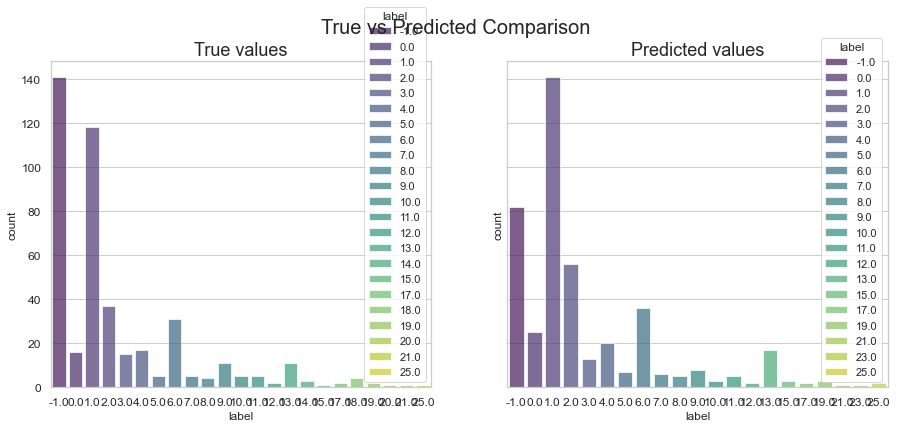

In [83]:
bayes.visualize(y_test, predictions, 'label')

In [84]:
qry = 1
matrix = np.zeros((2,2), dtype=int)
docs = pca_df_dbscan[pca_df_dbscan['label'] == pca_df_normalized_queries.loc[qry-1]['label']]
docs['Document']=docs.index+1
lab = pca_df_normalized_queries.loc[qry-1]['label']
p = pca_df_normalized[pca_df_normalized['label'] == lab]
cols = ['doc','distance']
r = pd.DataFrame(columns=cols)
for doc in p.index+1:
    r = r.append({'doc':doc,'distance':_distance(pca_df_normalized_queries.loc[qry-1,0:1],p.loc[doc-1,0:1])}, ignore_index=True)
r = r.sort_values(by=['distance'], ascending=True).head(10)
docs = docs[docs['Document'].isin(r['doc'])]
docs['Pertinent']= docs['Document'].apply(lambda x: 'Oui' if x in rel_set[qry] else 'Non')
try:
    p=docs['Pertinent'].value_counts()['Oui']
except:
    p=0
docs['Precision']=0.0
docs['Rappel']=0.0
c=0
for i in docs.head(10)['Document']:
    if docs['Pertinent'][i-1] == 'Oui':
        c+=1
    docs['Precision'][i-1] = c/(i+1)
    try:
        docs['Rappel'][i-1] = c/p
    except:
        docs['Rappel'][i-1] = 0
try:
    p5.append(docs['Precision'].iloc[4])
except:
    p5.append(np.nan)
try:
    p10.append(docs['Precision'].iloc[9])
except:
    p10.append(np.nan)
np.arange(1,len(doc_set)+1)
matrix[0][0] += p
temp = [doc not in np.array(docs.index+1) for doc in np.array(rel_set[qry])]
matrix[0][1] += temp.count(True)
temp = [doc not in np.array(rel_set[qry]) for doc in np.array(docs[(docs['Pertinent']=='Non')].index+1)]
matrix[1][0] += temp.count(True)
temp = [doc not in np.array(rel_set[qry]) for doc in np.array(pca_df_dbscan[pca_df_dbscan['label'] != pca_df_normalized_queries.loc[0]['label']].index+1)]
matrix[1][1] += temp.count(True)
acc.append(accuracy(matrix))
prec.append(precision(matrix))
rapp.append(rappel(matrix))
f1.append(f1_score(matrix))
spec.append(specificity(matrix))
sens.append(sensitivity(matrix))

In [85]:
matrix

array([[   0,   46],
       [  10, 1266]])

In [89]:
docs['Precision'].iloc[4]

0.0

In [90]:
docs['Precision'].iloc[9]

0.0

In [53]:
col1 = ['query','P@5','P@10']
rc = pd.DataFrame(columns=col1)
p5 = []
p10 = []
acc = []
prec = []
rapp = []
f1 = []
spec = []
sens = []
for query in tqdm_notebook(rel_set.keys()):
    c = Cosine(df_freqs_poids_porter, qry_set[query], 'P')    
    cosine = c.copy().head(10)
    cosine['Pertinent'] = cosine['Document'].apply(lambda x: 'Oui' if x in rel_set[query] else 'Non')
    cosine['Precision'] = 0.0
    cosine['Rappel'] = 0.0
    cosine['F-measure'] = 0.0
    cr=0
    try:
        p=cosine['Pertinent'].value_counts()['Oui']
    except:
        p=0
    for i in range (0,10):
        if cosine['Pertinent'].iloc[i] == 'Oui':
            cr+=1
        cosine['Precision'].iloc[i] = cr/(i+1)
        try:
            cosine['Rappel'].iloc[i] = cr/p
        except:
            cosine['Rappel'].iloc[i] = 0
        cosine['F-measure'].iloc[i] = 2*cosine['Precision'].iloc[i]*cosine['Rappel'].iloc[i]/(cosine['Precision'].iloc[i]+cosine['Rappel'].iloc[i])
    try:
        p5.append(cosine['Precision'].iloc[4])
        p_5= cosine['Precision'].iloc[4]
    except:
        p5.append(np.nan)
        p_5 = np.nan
    try:
        p10.append(cosine['Precision'].iloc[9])
        p_10 = cosine['Precision'].iloc[9]
    except:
        p10.append(np.nan)
        p_10 = np.nan
    rc = rc.append({'query':query,'P@5':p_5,'P@10':p_10}, ignore_index=True)
    matrix = np.zeros((2,2), dtype=int)
    l = [a in rel_set[query] for a in c[c['Mesure Cosine']!=0]['Document'] ]
    matrix[0][0] = l.count(True)
    l = [a in rel_set[query] for a in c[c['Mesure Cosine']==0]['Document'] ]
    matrix[0][1] = l.count(True)
    l = [a not in rel_set[query] for a in c[c['Mesure Cosine']!=0]['Document'] ]
    matrix[1][0] = l.count(True)
    l = [a not in rel_set[query] for a in c[c['Mesure Cosine']==0]['Document'] ]
    matrix[1][1] = l.count(True)
    acc.append(accuracy(matrix))
    prec.append(precision(matrix))
    rapp.append(rappel(matrix))
    f1.append(f1_score(matrix))
    spec.append(specificity(matrix))
    sens.append(sensitivity(matrix))
cosine_dic = {
    'accuracy' : np.nanmean(acc),
    'precision' : np.nanmean(prec),
    'rappel' : np.nanmean(rapp),
    'f1_score' : np.nanmean(f1),
    'specificity' : np.nanmean(spec),
    'sensitivity' : np.nanmean(sens),
    'p@5' : np.nanmean(p5),
    'p@10' : np.nanmean(p10)
}



  0%|          | 0/76 [00:00<?, ?it/s]

In [54]:
rc.to_excel('cosine_results.xlsx', index=False)

In [55]:
cosine_dic

{'accuracy': 0.22617159336697912,
 'precision': 0.03504197206165916,
 'rappel': 0.9599764717635094,
 'f1_score': 0.06567320856183438,
 'specificity': 0.9946086201012181,
 'sensitivity': 0.03504197206165916,
 'p@5': 0.3052631578947368,
 'p@10': 0.27894736842105267}

In [56]:
rp = pd.DataFrame(columns=['query','P@5','P@10'])
p5 = []
p10 = []
acc = []
prec = []
rapp = []
f1 = []
spec = []
sens = []
for query in tqdm_notebook(rel_set.keys()):
    pr = produit_scalaire(df_freqs_poids_porter, qry_set[query], 'P')[1].sort_values(by='Poid', ascending=False)
  
    pr['Pertinent'] = pr['Document'].apply(lambda x: 'Oui' if x in rel_set[query] else 'Non')
    produit = pr.copy().head(10)
    produit['Precision'] = 0.0
    produit['Rappel'] = 0.0
    produit['F-measure'] = 0.0
    cr=0
    try:
        p=produit['Pertinent'].value_counts()['Oui']
    except:
        p=0
    for i in range (0,10):
        if produit['Pertinent'].iloc[i] == 'Oui':
            cr+=1
        produit['Precision'].iloc[i] = cr/(i+1)
        try:
            produit['Rappel'].iloc[i] = cr/p
        except:
            produit['Rappel'].iloc[i] = 0
    
    try:
        p5.append(produit['Precision'].iloc[4])
        p_5= produit['Precision'].iloc[4]
    except:
        p5.append(np.nan)
        p_5 = np.nan
    try:
        p10.append(produit['Precision'].iloc[9])
        p_10 = produit['Precision'].iloc[9]
    except:
        p10.append(np.nan)
        p_10 = np.nan
    rp = rp.append({'query':query,'P@5':p_5,'P@10':p_10}, ignore_index=True)
    matrix = np.zeros((2,2), dtype=int)
    l = [a in rel_set[query] for a in pr[pr['Poid']!=0]['Document'] ]
    matrix[0][0] = l.count(True)
    l = [a in rel_set[query] for a in pr[pr['Poid']==0]['Document'] ]
    matrix[0][1] = l.count(True)
    l = [a not in rel_set[query] for a in pr[pr['Poid']!=0]['Document'] ]
    matrix[1][0] = l.count(True)
    l = [a not in rel_set[query] for a in pr[pr['Poid']==0]['Document'] ]
    matrix[1][1] = l.count(True)
    acc.append(accuracy(matrix))
    prec.append(precision(matrix))
    rapp.append(rappel(matrix))
    f1.append(f1_score(matrix))
    spec.append(specificity(matrix))
    sens.append(sensitivity(matrix))
produit_dic = {
    'accuracy' : np.nanmean(acc),
    'precision' : np.nanmean(prec),
    'rappel' : np.nanmean(rapp),
    'f1_score' : np.nanmean(f1),
    'specificity' : np.nanmean(spec),
    'sensitivity' : np.nanmean(sens),
    'p@5' : np.nanmean(p5),
    'p@10' : np.nanmean(p10)
}


    


  0%|          | 0/76 [00:00<?, ?it/s]

In [57]:
rp.to_excel('produit_results.xlsx', index=False)

In [58]:
produit_dic

{'accuracy': 0.22617159336697912,
 'precision': 0.03504197206165916,
 'rappel': 0.9599764717635094,
 'f1_score': 0.06567320856183438,
 'specificity': 0.9946086201012181,
 'sensitivity': 0.03504197206165916,
 'p@5': 0.2921052631578947,
 'p@10': 0.26447368421052636}

In [61]:
jr = pd.DataFrame(columns=['query','P@5','P@10'])
p5 = []
p10 = []
acc = []
prec = []
rapp = []
f1 = []
spec = []
sens = []
for query in tqdm_notebook(rel_set.keys()):
    jaccard = Jaccard(df_freqs_poids_porter, qry_set[query], 'P')
    
    jaccard['Pertinent'] = jaccard['Document'].apply(lambda x: 'Oui' if x in rel_set[query] else 'Non')
    j = jaccard.copy().head(10)
    j['Precision'] = 0.0
    j['Rappel'] = 0.0
    j['F-measure'] = 0.0
    cr=0
    try:
        p=j['Pertinent'].value_counts()['Oui']
    except:
        p=0
    for i in range (0,10):
        if j['Pertinent'].iloc[i] == 'Oui':
            cr+=1
        j['Precision'].iloc[i] = cr/(i+1)
        try:
            j['Rappel'].iloc[i] = cr/p
        except:
            j['Rappel'].iloc[i] = 0
    try:
        p5.append(j['Precision'].iloc[4])
        p_5= j['Precision'].iloc[4]
    except:
        p5.append(np.nan)
        p_5 = np.nan
    try:
        p10.append(j['Precision'].iloc[9])
        p_10 = j['Precision'].iloc[9]
    except:
        p10.append(np.nan)
        p_10 = np.nan
    jr = jr.append({'query':query,'P@5':p_5,'P@10':p_10}, ignore_index=True)
    matrix = np.zeros((2,2), dtype=int)
    l = [a in rel_set[query] for a in jaccard[jaccard['Mesure Jaccard']!=0]['Document'] ]
    matrix[0][0] = l.count(True)
    l = [a in rel_set[query] for a in jaccard[jaccard['Mesure Jaccard']==0]['Document'] ]
    matrix[0][1] = l.count(True)
    l = [a not in rel_set[query] for a in jaccard[jaccard['Mesure Jaccard']!=0]['Document'] ]
    matrix[1][0] = l.count(True)
    l = [a not in rel_set[query] for a in jaccard[jaccard['Mesure Jaccard']==0]['Document'] ]
    matrix[1][1] = l.count(True)
    acc.append(accuracy(matrix))
    prec.append(precision(matrix))
    rapp.append(rappel(matrix))
    f1.append(f1_score(matrix))
    spec.append(specificity(matrix))
    sens.append(sensitivity(matrix))
jaccard_dic = {
    'accuracy' : np.nanmean(acc),
    'precision' : np.nanmean(prec),
    'rappel' : np.nanmean(rapp),
    'f1_score' : np.nanmean(f1),
    'specificity' : np.nanmean(spec),
    'sensitivity' : np.nanmean(sens),
    'p@5' : np.nanmean(p5),
    'p@10' : np.nanmean(p10)
}
    

  0%|          | 0/76 [00:00<?, ?it/s]

In [62]:
jr

query  P@5  P@10
0     1.0  0.4   0.2
1     2.0  0.2   0.2
2     3.0  0.8   0.8
3     4.0  0.0   0.1
4     5.0  0.2   0.1
..    ...  ...   ...
71  101.0  0.0   0.0
72  102.0  0.4   0.4
73  104.0  0.0   0.0
74  109.0  0.8   0.6
75  111.0  0.4   0.2

[76 rows x 3 columns]

In [63]:
jaccard_dic

{'accuracy': 0.22617159336697912,
 'precision': 0.03504197206165916,
 'rappel': 0.9599764717635094,
 'f1_score': 0.06567320856183438,
 'specificity': 0.9946086201012181,
 'sensitivity': 0.03504197206165916,
 'p@5': 0.3078947368421052,
 'p@10': 0.26710526315789473}

In [64]:
jr.to_excel('jaccard_results.xlsx', index=False)

In [71]:
bm = pd.DataFrame(columns=['query','P@5','P@10'])
p5 = []
p10 = []
acc = []
prec = []
rapp = []
f1 = []
spec = []
sens = []
for query in tqdm_notebook(rel_set.keys()):
    bm25 = BM25(df_freqs_poids_porter, qry_set[query], 'P')
    
    bm25['Pertinent'] = bm25['Document'].apply(lambda x: 'Oui' if x in rel_set[query] else 'Non')
    b = bm25.copy().head(10)
    b['Precision'] = 0.0
    b['Rappel'] = 0.0
    b['F-measure'] = 0.0
    cr=0
    try:
        p=b['Pertinent'].value_counts()['Oui']
    except:
        p=0
    for i in range (0,10):
        if b['Pertinent'].iloc[i] == 'Oui':
            cr+=1
        b['Precision'].iloc[i] = cr/(i+1)
        try:
            b['Rappel'].iloc[i] = cr/p
        except:
            b['Rappel'].iloc[i] = 0
    try:
        p5.append(b['Precision'].iloc[4])
        p_5= b['Precision'].iloc[4]
    except:
        p5.append(np.nan)
        p_5 = np.nan
    try:
        p10.append(b['Precision'].iloc[9])
        p_10 = b['Precision'].iloc[9]
    except:
        p10.append(np.nan)
        p_10 = np.nan
    bm = bm.append({'query':query,'P@5':p_5,'P@10':p_10}, ignore_index=True)
    matrix = np.zeros((2,2), dtype=int)
    l = [a in rel_set[query] for a in bm25[bm25['Probabilite BM25']!=0]['Document'] ]
    matrix[0][0] = l.count(True)
    l = [a in rel_set[query] for a in bm25[bm25['Probabilite BM25']==0]['Document'] ]
    matrix[0][1] = l.count(True)
    l = [a not in rel_set[query] for a in bm25[bm25['Probabilite BM25']!=0]['Document'] ]
    matrix[1][0] = l.count(True)
    l = [a not in rel_set[query] for a in bm25[bm25['Probabilite BM25']==0]['Document']]
    matrix[1][1] = l.count(True)
    acc.append(accuracy(matrix))
    prec.append(precision(matrix))
    rapp.append(rappel(matrix))
    f1.append(f1_score(matrix))
    spec.append(specificity(matrix))
    sens.append(sensitivity(matrix))
bm_dic = {
    'accuracy' : np.nanmean(acc),
    'precision' : np.nanmean(prec),
    'rappel' : np.nanmean(rapp),
    'f1_score' : np.nanmean(f1),
    'specificity' : np.nanmean(spec),
    'sensitivity' : np.nanmean(sens),
    'p@5' : np.nanmean(p5),
    'p@10' : np.nanmean(p10)
}

  0%|          | 0/76 [00:00<?, ?it/s]

In [72]:
bm

query  P@5  P@10
0     1.0  0.2   0.3
1     2.0  0.2   0.1
2     3.0  0.8   0.4
3     4.0  0.4   0.2
4     5.0  0.2   0.1
..    ...  ...   ...
71  101.0  0.0   0.0
72  102.0  0.4   0.5
73  104.0  0.0   0.1
74  109.0  0.8   0.6
75  111.0  0.2   0.2

[76 rows x 3 columns]

In [73]:
bm_dic

{'accuracy': 0.22617159336697912,
 'precision': 0.03504197206165916,
 'rappel': 0.9599764717635094,
 'f1_score': 0.06567320856183438,
 'specificity': 0.9946086201012181,
 'sensitivity': 0.03504197206165916,
 'p@5': 0.3447368421052632,
 'p@10': 0.3052631578947369}

In [74]:
bm.to_excel('bm25_results.xlsx', index=False)

In [280]:
df = pd.read_csv('distances.csv')
rds = pd.DataFrame(columns=['query','P@5','P@10'])
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df)
x_pca = pca.transform(df)
pca_df = pd.DataFrame(x_pca)
pca_df
from sklearn import preprocessing
x = pca_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pca_df_normalized = pd.DataFrame(x_scaled)
X = pca_df_normalized.to_numpy()
eps = [ 0.0222221]
min_pts = [7]
cols = ['eps', 'min_pts','clusters','Bayes accuracy','P@5','P@10', 'accuracy', 'precision', 'rappel', 'f1_score', 'specificity', 'sensitivity']
res = pd.DataFrame(columns=cols)
for ep in tqdm_notebook (eps) :
    for minpt in min_pts:
        dbscan = DBSCAN(eps=ep, min_pts=minpt, data=X)
        dbscan.fit()
        clusters = dbscan.get_clusters()
        noise = dbscan.get_noise()
        pca_df_normalized['label'] = np.nan
        for cluster in range (len(clusters)):
            for element in clusters[cluster]:
                #assign cluster number to each element
                pca_df_normalized.loc[element]['label'] = cluster
        for element in noise:
            #assign cluster number to each element
            pca_df_normalized.loc[element]['label'] = -1
        cl = len(np.unique(pca_df_normalized['label']))
        X_train, X_test, y_train, y_test = train_test_split(pca_df_normalized, test_size=0.3)
        bayes= NaiveBayesClassifier()
        bayes.fit(X_train.squeeze(), y_train.squeeze())
        predictions = bayes.predict(X_test.squeeze())
        while (len(np.unique(predictions)) < len(np.unique(pca_df_normalized['label']))/2):
            X_train, X_test, y_train, y_test = train_test_split(pca_df_normalized, test_size=0.3)
            bayes= NaiveBayesClassifier()
            bayes.fit(X_train.squeeze(), y_train.squeeze())
            predictions = bayes.predict(X_test.squeeze())
        #bayes.visualize(y_test, predictions, 'label')
        ba = bayes.accuracy(y_test, predictions)
        matrix = np.zeros((2,2), dtype=int)
        pca_df_dbscan = pca_df_normalized.copy()
        queries_porter = pd.read_csv('queries_porter.csv')
        pca = PCA(n_components=2)
        pca.fit(queries_porter)
        x_pca = pca.transform(queries_porter)
        pca_df = pd.DataFrame(x_pca)
        pca_df
        x = pca_df.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        pca_df_normalized_queries = pd.DataFrame(x_scaled)
        pca_df_normalized_queries['label']=bayes.predict(pca_df_normalized_queries)
        p5 = []
        p10 = []
        acc = []
        prec = []
        rapp = []
        f1 = []
        spec = []
        sens = []
        for qry in tqdm_notebook(rel_set.keys()):
            matrix = np.zeros((2,2), dtype=int)
            docs = pca_df_dbscan[pca_df_dbscan['label'] == pca_df_normalized_queries.loc[qry-1]['label']]
            docs['Document']=docs.index+1
            docs['Distance'] = np.nan
            lab = pca_df_normalized_queries.loc[qry-1]['label']
            # p = pca_df_normalized[pca_df_normalized['label'] == lab]
            #cols = ['doc','distance']
            #r = pd.DataFrame(columns=cols)
            for doc in docs.index+1:
                docs['Distance'].loc[doc-1] = _distance(pca_df_normalized_queries.loc[qry-1,0:1],docs.loc[doc-1][0:2].values)
                #r = r.append({'doc':doc,'distance':_distance(pca_df_normalized_queries.loc[qry-1,0:1],p.loc[doc-1,0:1])}, ignore_index=True)
            docs = docs.sort_values(by=['Distance'], ascending=True)
            pr = docs.head(10)
            docs['Pertinent']= docs['Document'].apply(lambda x: 'Oui' if x in rel_set[qry] else 'Non')
            # pr['Pertinent'] = pr['Document'].apply(lambda x: 'Oui' if x in rel_set[qry] else 'Non')
            try:
                p=docs['Pertinent'].value_counts()['Oui']
            except:
                p=0
            docs['Precision']=0.0
            docs['Rappel']=0.0
            c=0
            for i in range(0,10):
                try:
                    if docs['Pertinent'].iloc[i] == 'Oui':
                        c+=1
                    docs['Precision'].iloc[i] = c/(i+1)
                    try:
                        docs['Rappel'].iloc[i] = c/p
                    except:
                        docs['Rappel'].iloc[i] = 0
                except:
                    pass
            try:
                p5.append(docs['Precision'].iloc[4])
                p_5 = pr['Precision'].iloc[4]
            except:
                p5.append(np.nan)
            try:
                p10.append(docs['Precision'].iloc[9])
                p_10 = pr['Precision'].iloc[9]
            except:
                p10.append(np.nan)
            rds = rds.append({'query':qry,'p5':p_5,'p10':p_10}, ignore_index=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [284]:
rds = pd.DataFrame(columns=['query','p5','p10'])
for qry in qry_set.keys():
    try:
        r = roc_curve(df_freqs_poids_porter,qry,'Datamining')
        rds = rds.append({'query':qry,'p5' : r['Precision'].iloc[4],'p10' : r['Precision'].iloc[9]}, ignore_index=True)
    except:
        pass

0
0
1
0
1
0
0
0
0
0
1
0
2
0
0
1
0
0
0
2
1
0
0
0
3
2
8
0
1
0
2
0
0
1
0
1
1
1
0
0
1
0
0
1
1
0
1
0
0
0
1
0
0
0
2
0
0
2
2
0
0
0
0
1
0
0
0
0
0
0
0
0
2
0
0
0


In [287]:
rds.to_excel('dbscan_results.xlsx', index=False)

In [301]:
final = pd.DataFrame(columns=['Mesure','accuracy','recall','precision','sensitivity','specificity','f1_score','p5','p10'])
final = final.append({'Mesure' : 'Produit Scalaire','accuracy' : produit_dic['accuracy'],'recall' : produit_dic['rappel'],'precision' : produit_dic['precision'],'sensitivity' : produit_dic['sensitivity'],'specificity' : produit_dic['specificity'],'f1_score' : produit_dic['f1_score'],'p5' : produit_dic['p@5'],'p10' : produit_dic['p@10']}, ignore_index=True)

In [302]:
final = final.append({'Mesure' : 'Cosinus','accuracy' : cosine_dic['accuracy'], 'recall' : cosine_dic['rappel'],'precision' : cosine_dic['precision'],'sensitivity' : cosine_dic['sensitivity'],'specificity' : cosine_dic['specificity'],'f1_score' : cosine_dic['f1_score'],'p5' : cosine_dic['p@5'],'p10' : cosine_dic['p@10']}, ignore_index=True)

In [303]:
final = final.append({'Mesure' : 'Jaccard','accuracy' : jaccard_dic['accuracy'], 'recall' : jaccard_dic['rappel'],'precision' : jaccard_dic['precision'],'sensitivity' : jaccard_dic['sensitivity'],'specificity' : jaccard_dic['specificity'],'f1_score' : jaccard_dic['f1_score'],'p5' : jaccard_dic['p@5'],'p10' : jaccard_dic['p@10']}, ignore_index=True)

In [304]:
final = final.append({'Mesure' : 'BM25','accuracy' : bm_dic['accuracy'], 'recall' : bm_dic['rappel'],'precision' : bm_dic['precision'],'sensitivity' : bm_dic['sensitivity'],'specificity' : bm_dic['specificity'],'f1_score' : bm_dic['f1_score'],'p5' : bm_dic['p@5'],'p10' : bm_dic['p@10']}, ignore_index=True)

In [305]:
bench = pd.read_excel('benchmark_F.xlsx')

In [312]:
bench.iloc[13]

eps                0.022222
min_pts            7.000000
clusters          27.000000
Bayes accuracy     0.805936
P@5                0.000538
P@10               0.000483
accuracy           0.803858
precision          0.005534
recall             0.018877
f1_score           0.016050
specificity        0.976527
sensitivity        0.005534
Name: 13, dtype: float64

In [308]:
final = final.append({'Mesure' : 'Data Mining','accuracy' : bench.iloc[13]['accuracy'], 'recall' : bench.iloc[13]['recall'],'precision' : bench.iloc[13]['precision'],'sensitivity' : bench.iloc[13]['sensitivity'],'specificity' : bench.iloc[13]['specificity'],'f1_score' : bench.iloc[13]['f1_score'],'p5' : bench.iloc[13]['P@5'],'p10' : bench.iloc[13]['P@10']}, ignore_index=True)

In [313]:
final.to_excel('final.xlsx', index=False)